# simple synthetic inversion

Here we try to recover the true Layer 1 topography with a gravity inversion. We start with the forward gravity of Layer 1 as the observed gravity, then down-sample this gravity to represent a coarser gravity survey, and final, repeate these steps with a regional component including in the observed gravity. The regional component is the forward gravity of Layer 2. 

We also explore adding gaussian noise to these gravity data. 

The starting (low-resolution) Layer 1 topography has been created through the random sampling and gridding of 30 points. In an Antarctic setting, these points represent single seismic survey locations which measure the elevation of Layer 1. 

import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import plotting, optimization, synthetic, regional
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import os
import pathlib
import string
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.contrib.itertools import product
from tqdm.autonotebook import tqdm
import pickle
import optuna
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sns.set_theme()

# Load data

## topographic layers
* 2 full resolution synthetic layers
* low resolution layer 2

In [2]:
layer1 = xr.open_zarr("../../synthetic_data/synthetic_layer1.zarr").z

starting_layer1 = xr.open_zarr("../../synthetic_data/synthetic_lowres_layer1.zarr").z

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
starting_layer1 = starting_layer1.astype(np.float64)

print(utils.get_grid_info(layer1))
print(utils.get_grid_info(starting_layer1))
starting_layer1

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -952.152099609, -481.448486328, 'g')
(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -950.269714355, -378.920135498, 'g')


<xarray.DataArray 'z' (northing: 73, easting: 93)>
dask.array<open_dataset-e1bbb7ecc6b0dd52c96800cb9875ee45z, shape=(73, 93), dtype=float64, chunksize=(73, 93), chunktype=numpy.ndarray>
Coordinates:
  * easting   (easting) float64 -6e+03 -5e+03 -4e+03 ... 8.4e+04 8.5e+04 8.6e+04
  * northing  (northing) float64 -6e+03 -5e+03 -4e+03 ... 6.5e+04 6.6e+04
Attributes:
    metadata:  Generated by Spline(mindist=0)

## gravity data
* full resolution forward gravity of Layer 1

In [3]:
# full resolution gravity point data
grav = pd.read_csv(
    "../../synthetic_data/synthetic_simple_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# Set region and parameters

Use the same regions and parameters as `synthetic_model_2layer.ipynb`

In [4]:
layer_spacing, buffer_region, _, _, registration = utils.get_grid_info(layer1)

# set gravity observation parameters
grav_observation_height = 1e3
grav_spacing = 1e3

inversion_region = utils.alter_region(
    buffer_region,
    zoom=6e3,
)[0]

# set density contrast
density = 2300 - 1024

print(f"spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

spacing: 1000.0m
registration: g
inversion region =  [0.0, 80000.0, 0.0, 60000.0]
buffer region =  [-6000.0, 86000.0, -6000.0, 66000.0]


# Prep data

## grav data

In [8]:
full_res_grav = inv_utils.prep_grav_data(
    grav,
    region=inversion_region,
    input_grav_name="Surface1",
    input_coord_names=("easting", "northing", "upward"),
)

print(f"full resolution gravity: {len(full_res_grav)} points")

print(f"gravity avg. elevation: {int(np.nanmean(full_res_grav.upward))}")

full resolution gravity: 19481 points
gravity avg. elevation: 1000


## constraint points

In [5]:
# load constraint points into a dataframe
constraints_all = pd.read_csv(
    "../../synthetic_data/synthetic_constraints.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraints = utils.points_inside_region(
    constraints_all, inversion_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraints)}")
constraints.head()

bathymetry control points:30


easting      northing      upward
0  33693.672357   7507.422695 -730.639763
1  56744.661502  25582.027000 -684.765417
2   2008.692486  55641.813688 -547.650670
3  24977.275520  31857.255958 -732.211495
4  13153.447702  40745.118381 -788.180820

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the starting Layer 1 density contrast. This will be the input into our inversion.


## layer 1 prisms

In [6]:
# create prisms around starting layer 1
# positive densities above reference, negative below
print(f"Layer 1 density contrast: {density}kgm-3")

layer1_prisms = inv_utils.grids_to_prisms(
    surface=starting_layer1,
    reference=starting_layer1.values.mean(),
    density=xr.where(
        starting_layer1 >= starting_layer1.values.mean(), density, -density
    ),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

Layer 1 density contrast: 1276kgm-3


## layer 1 gravity

In [10]:
# calculate gravity of layer1
layer1_grav_grid, layer1_grav_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    full_res_grav,
    names=["layer1_prisms"],
    remove_median=False,
    progressbar=True,
    plot=False,
)

full_res_grav["layer1_forward"] = layer1_grav_df.forward_total

full_res_grav

  0%|                                                 | 0/19481 [00:00<?, ?it/s]

northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  4.895946 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.832540 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.764286 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  4.692135 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.616825 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.822520  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.821796  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.821311  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.820943  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.820536  8.046806       8.867341  False  1000.0   

       layer1_forward  
0            7.336436  
1            7.196777  
2            7.053205  
3            6.907357  
4            6.760484  
...               ...  
19476        0.539365  
19477        0.610158  
19478        0.680730  
19479        0.750859  
19480        0.820233  

[19481 rows x 8 columns]

## Misfit

In [19]:
full_res_grav = inv.misfit(
    input_grav=full_res_grav,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraints,
)

DC shifted observed gravity by -0.97mGal to match forward gravity.


### Save and load results

In [12]:
full_res_grav.to_csv(
    "../../synthetic_data/synthetic_simple_starting_model_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [7]:
full_res_grav = pd.read_csv(
    "../../synthetic_data/synthetic_simple_starting_model_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

full_res_grav

northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  4.895946 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.832540 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.764286 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  4.692135 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.616825 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.822520  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.821796  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.821311  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.820943  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.820536  8.046806       8.867341  False  1000.0   

       layer1_forward  Gobs_shift    misfit  
0            7.336436    5.870426 -1.466010  
1            7.196777    5.807020 -1.389757  
2            7.053205    5.738766 -1.314439  
3            6.907357    5.666615 -1.240742  
4            6.760484    5.591305 -1.169179  
...               ...         ...       ...  
19476        0.539365    1.797000  1.257635  
19477        0.610158    1.796276  1.186118  
19478        0.680730    1.795791  1.115061  
19479        0.750859    1.795423  1.044564  
19480        0.820233    1.795015  0.974782  

[19481 rows x 10 columns]

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


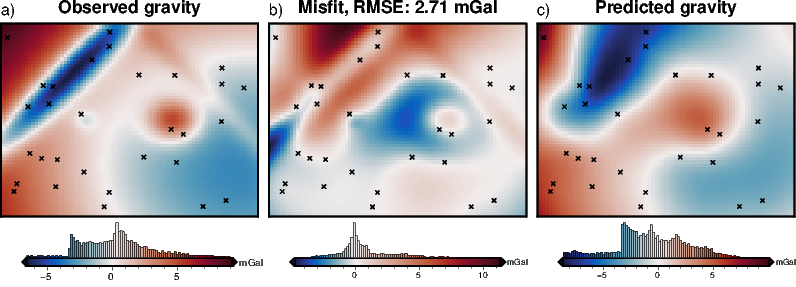

In [29]:
plotting.misfit_plotting(
    full_res_grav[~full_res_grav.test],
    constraints=constraints,
    robust=False,
    plot_type="pygmt",
    points_style="x.2c",
    points_pen="1p",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
)

# Constraints grid

In [16]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist
# starting_prisms.weights.plot()

grd2cpt [WARNING]: dense is a discrete CPT. You can stretch it (-T<min>/<max>) but not interpolate it (-T<min>/<max>/<inc>).
grd2cpt [WARNING]: Selecting the given range and ignoring the increment setting.


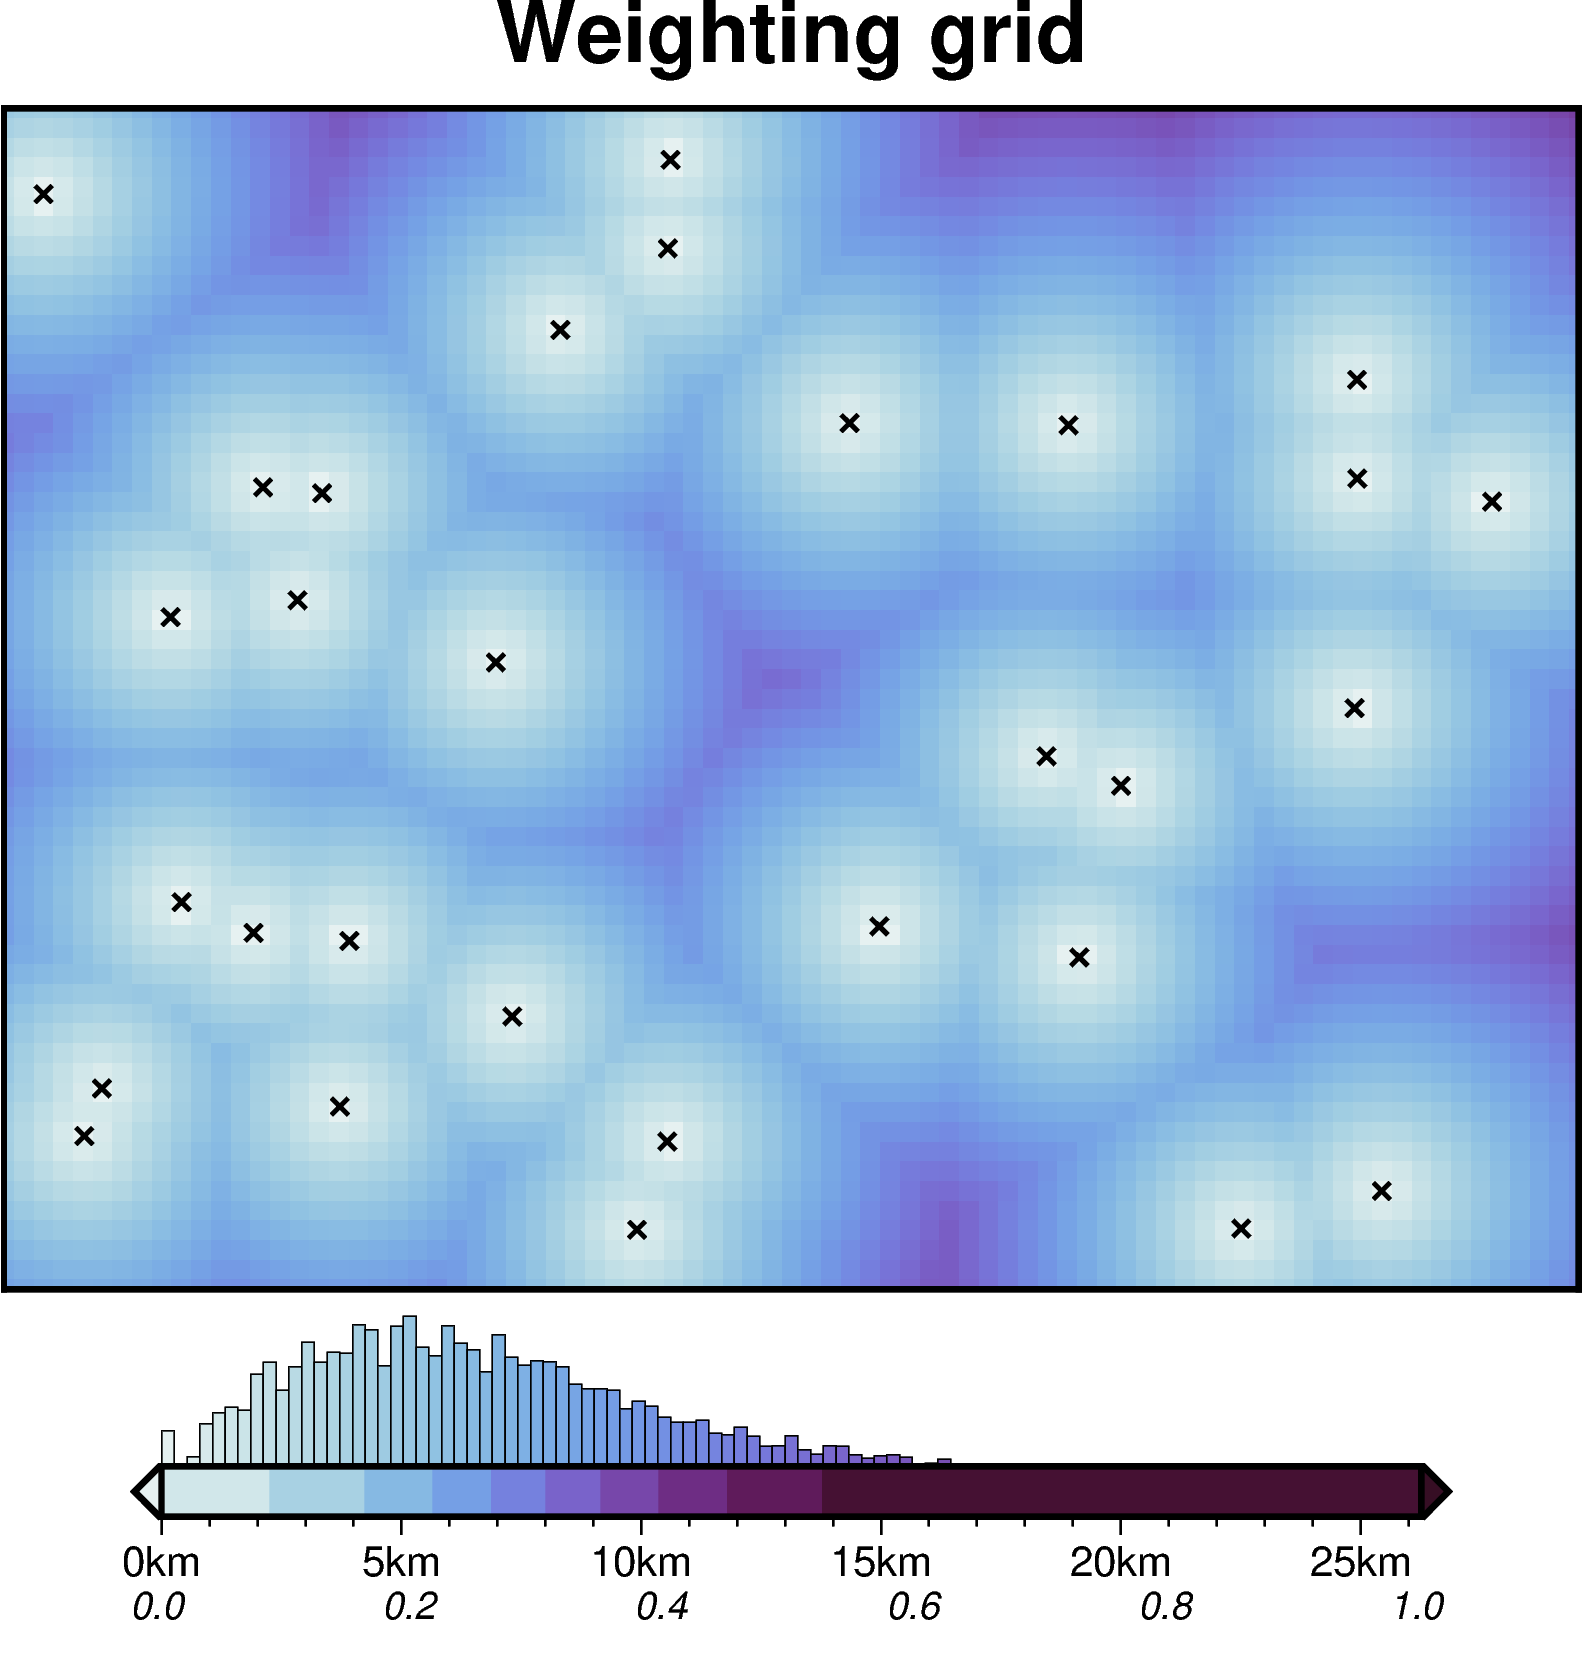

In [15]:
min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
)

fig = maps.plot_grd(
    min_dist,
    region=inversion_region,
    fig_height=10,
    title="Weighting grid",
    cmap="dense",
    hist=True,
    cbar_yoffset=1.5,
    cbar_unit_annot="km",
    cbar_scale=0.001,
)

fig.plot(
    x=constraints.easting,
    y=constraints.northing,
    style="x0.2c",
    pen="1p",
)

pygmt.grd2cpt(
    grid=starting_prisms.weights,
    background="i",
    cmap="dense",
)
with pygmt.config(
    FONT_ANNOT="Helvetica-Oblique",
    MAP_ANNOT_OFFSET_PRIMARY="18p",
    MAP_TICK_LENGTH_PRIMARY="0p",
):
    maps.add_colorbar(fig=fig, cbar_yoffset=1.5)

fig.show()

In [15]:
# min_dist = inv_utils.normalized_mindist(constraints, starting_prisms,)

# fig = maps.plot_grd(
#     min_dist,
#     region=inversion_region,
#     fig_height=10,
#     title="Minimum distance to constraints",
#     cmap="dense",
#     hist=True,
#     cbar_yoffset=1.5,
#     cbar_unit_annot="km",
#     cbar_scale=.001,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="18p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )
# fig.plot(
#     x = constraints.easting,
#     y = constraints.northing,
#     style = "x0.2c",
#     pen='1p',
# )
# fig = maps.plot_grd(
#     starting_prisms.weights,
#     region=inversion_region,
#     fig=fig,
#     origin_shift = "xshift",
#     title="Weighting grid",
#     # cbar_unit="m",
#     cmap="dense",
#     hist=True,
#     cbar_yoffset=1.5,
# )
# fig.plot(
#     x = constraints.easting,
#     y = constraints.northing,
#     style = "x0.2c",
#     pen='1p',
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="18p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )
# # pygmt.grd2cpt(grid = starting_prisms.weights, background="i", cmap="dense",)
# # with pygmt.config(
# #     FONT_ANNOT="Helvetica-Oblique",
# #     MAP_ANNOT_OFFSET_PRIMARY="18p",
# #     MAP_TICK_LENGTH_PRIMARY="0p", ):
# #     maps.add_colorbar(fig=fig, cbar_yoffset=1.5)

# fig.show()

# Set regional component to 0 for simple models

In [30]:
full_res_grav["reg"] = 0
full_res_grav["res"] = full_res_grav.misfit
print(full_res_grav.res.median())

full_res_grav

0.21671016501225182


northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  4.895946 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.832540 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.764286 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  4.692135 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.616825 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.822520  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.821796  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.821311  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.820943  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.820536  8.046806       8.867341  False  1000.0   

       layer1_forward  Gobs_shift  reg       res    misfit  
0            7.336436    5.870426    0 -1.466010 -1.466010  
1            7.196777    5.807020    0 -1.389757 -1.389757  
2            7.053205    5.738766    0 -1.314439 -1.314439  
3            6.907357    5.666615    0 -1.240742 -1.240742  
4            6.760484    5.591305    0 -1.169179 -1.169179  
...               ...         ...  ...       ...       ...  
19476        0.539365    1.797000    0  1.257635  1.257635  
19477        0.610158    1.796276    0  1.186118  1.186118  
19478        0.680730    1.795791    0  1.115061  1.115061  
19479        0.750859    1.795423    0  1.044564  1.044564  
19480        0.820233    1.795015    0  0.974782  0.974782  

[19481 rows x 12 columns]

# Inversion

## Full resolution grav, no noise

### With annulus approximation

Damping values: [0.0001     0.00021544 0.00046416 0.001      0.00215443 0.00464159
 0.01       0.02154435 0.04641589 0.1       ]
Best score: 0.047720703167922277
Best damping: 0.01


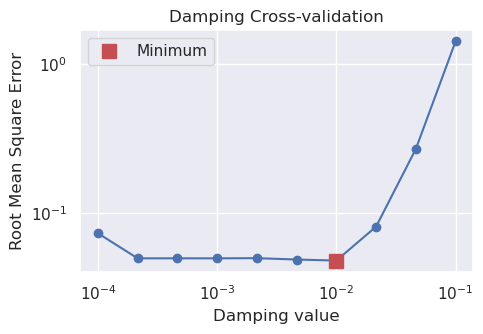

In [16]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist

# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    prism_layer=starting_prisms,
    max_iterations=100,
    l2_norm_tolerance=0.15,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    # deriv_type = "prisms",
    solver_type="scipy least squares",
    constraints=constraints,
)

fname = "../../synthetic_data/synthetic_simple_damping_CV_annulus"
# fname = "../../synthetic_data/synthetic_simple_damping_CV_prisms"
dampings = np.logspace(-4, -1, 10)
print(f"Damping values: {dampings}")

scores, rmses = inv.inversion_optimal_parameters(
    training_data=full_res_grav[full_res_grav.test == False],
    testing_data=full_res_grav[full_res_grav.test == True],
    parameter_values=dampings,
    function=inv.inversion_damping_MSE,
    plot=False,
    plot_grids=True,
    results_fname=fname,
    progressbar=True,
    true_surface=layer1,
    inversion_region=inversion_region,
    **kwargs,
)

# put scores and damping values into dict
CV_results = dict(scores=scores, dampings=dampings, rmses=rmses)

# remove if exists
pathlib.Path(fname).unlink(missing_ok=True)

# save scores and dampings to pickle
with open(f"{fname}.pickle", "wb") as f:
    pickle.dump(CV_results, f)

# load scores and dampings from pickle
with open(f"{fname}.pickle", "rb") as f:
    CV_results = pickle.load(f)

best = np.argmin(CV_results["scores"])
print("Best score:", CV_results["scores"][best])
print("Best damping:", CV_results["dampings"][best])

# get best inversion result of each set
with open(f"{fname}_trial_{best}.pickle", "rb") as f:
    inv_result = pickle.load(f)

plotting.plot_parameter_cv(
    CV_results["scores"],
    CV_results["dampings"],
    logx=True,
    logy=True,
    param_name="Damping",
)

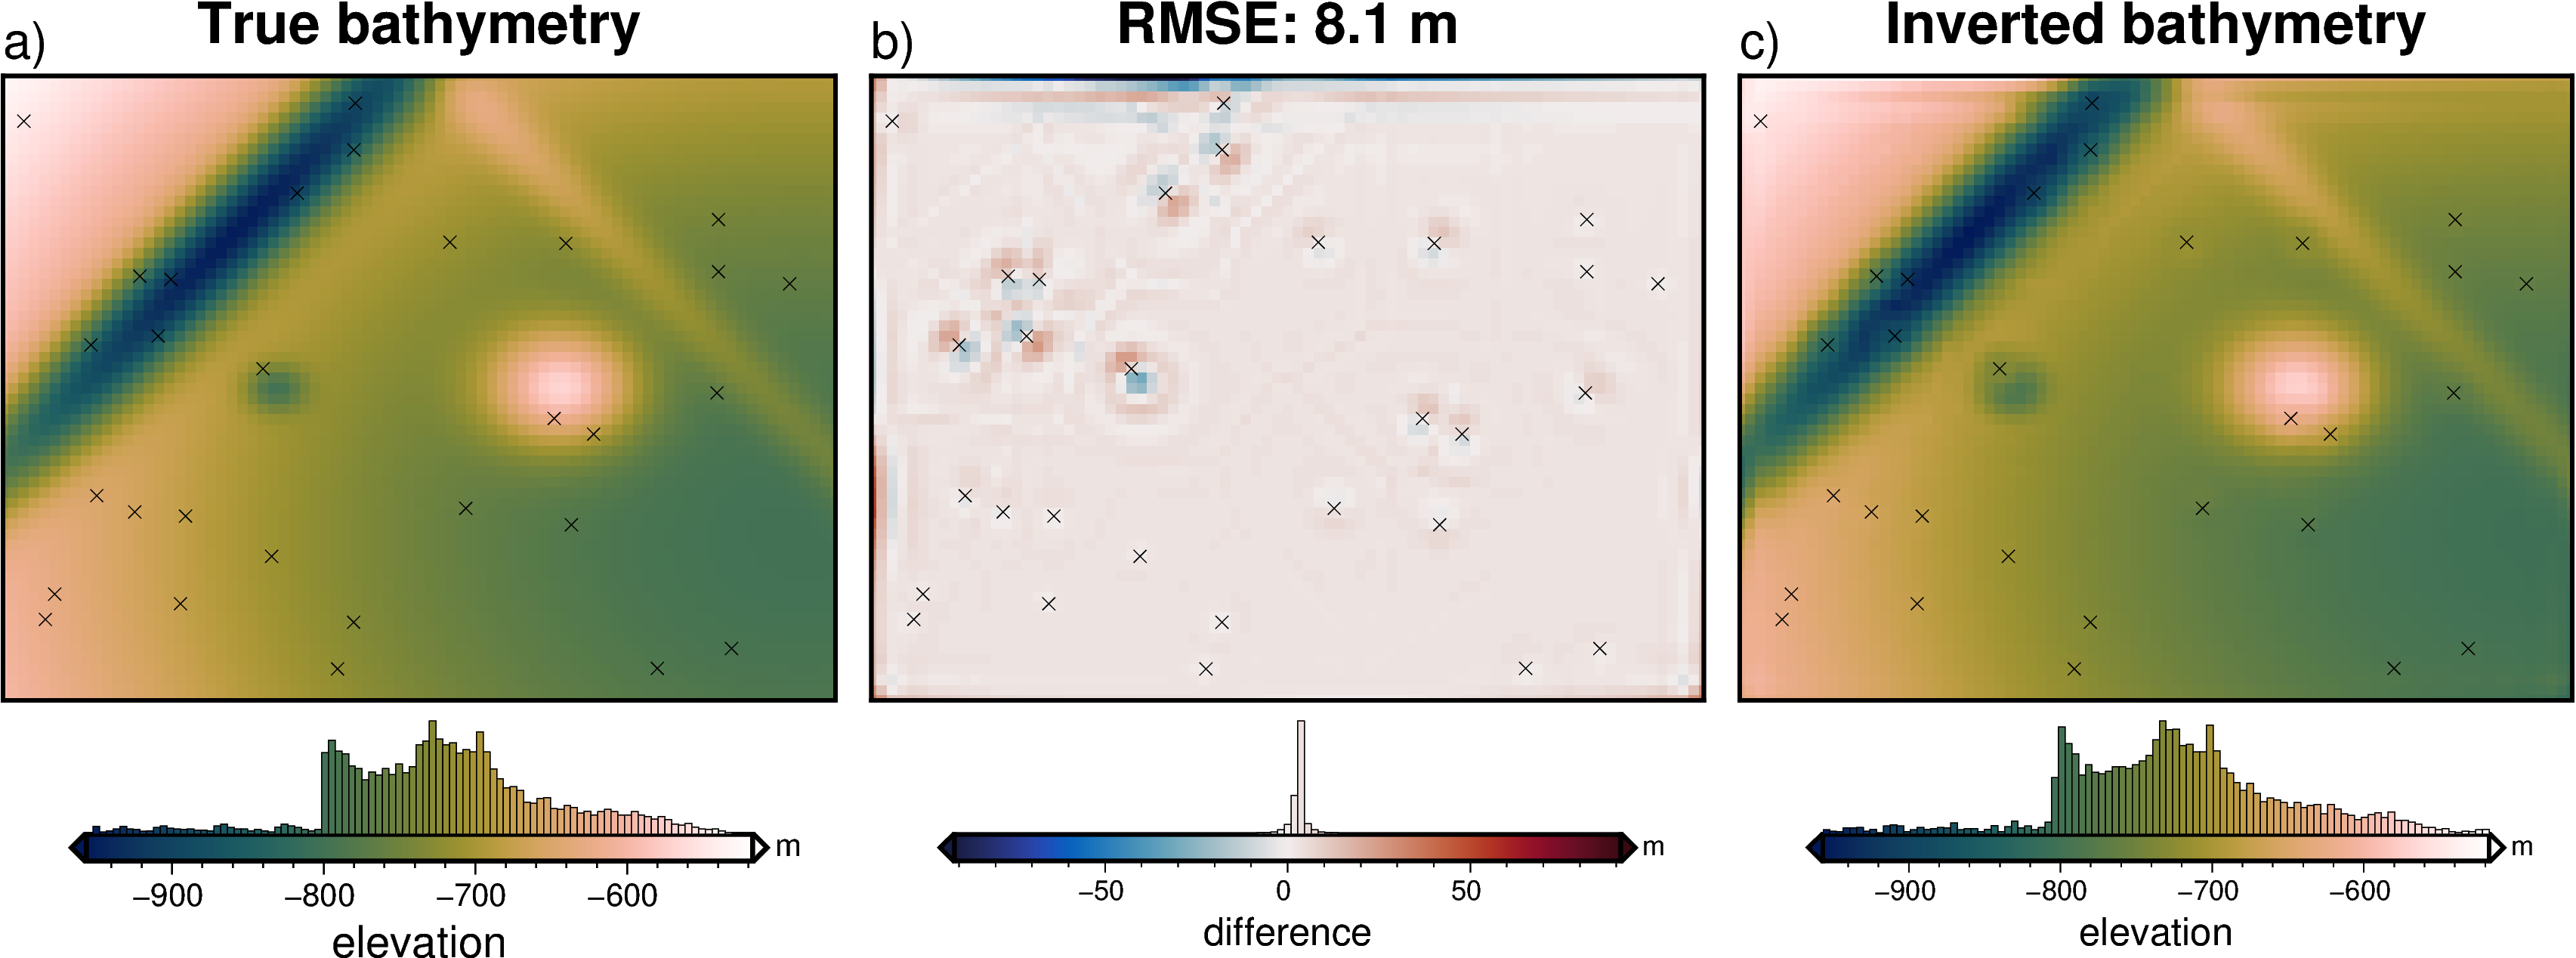

RMSE: 8.069290184741112
constraints RMSE: 1.19


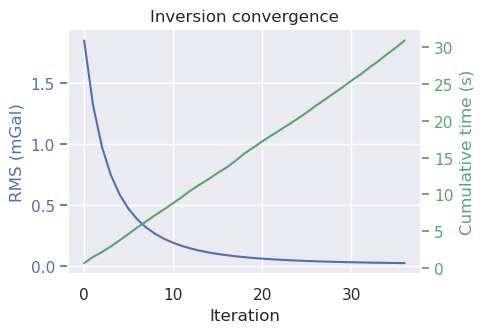

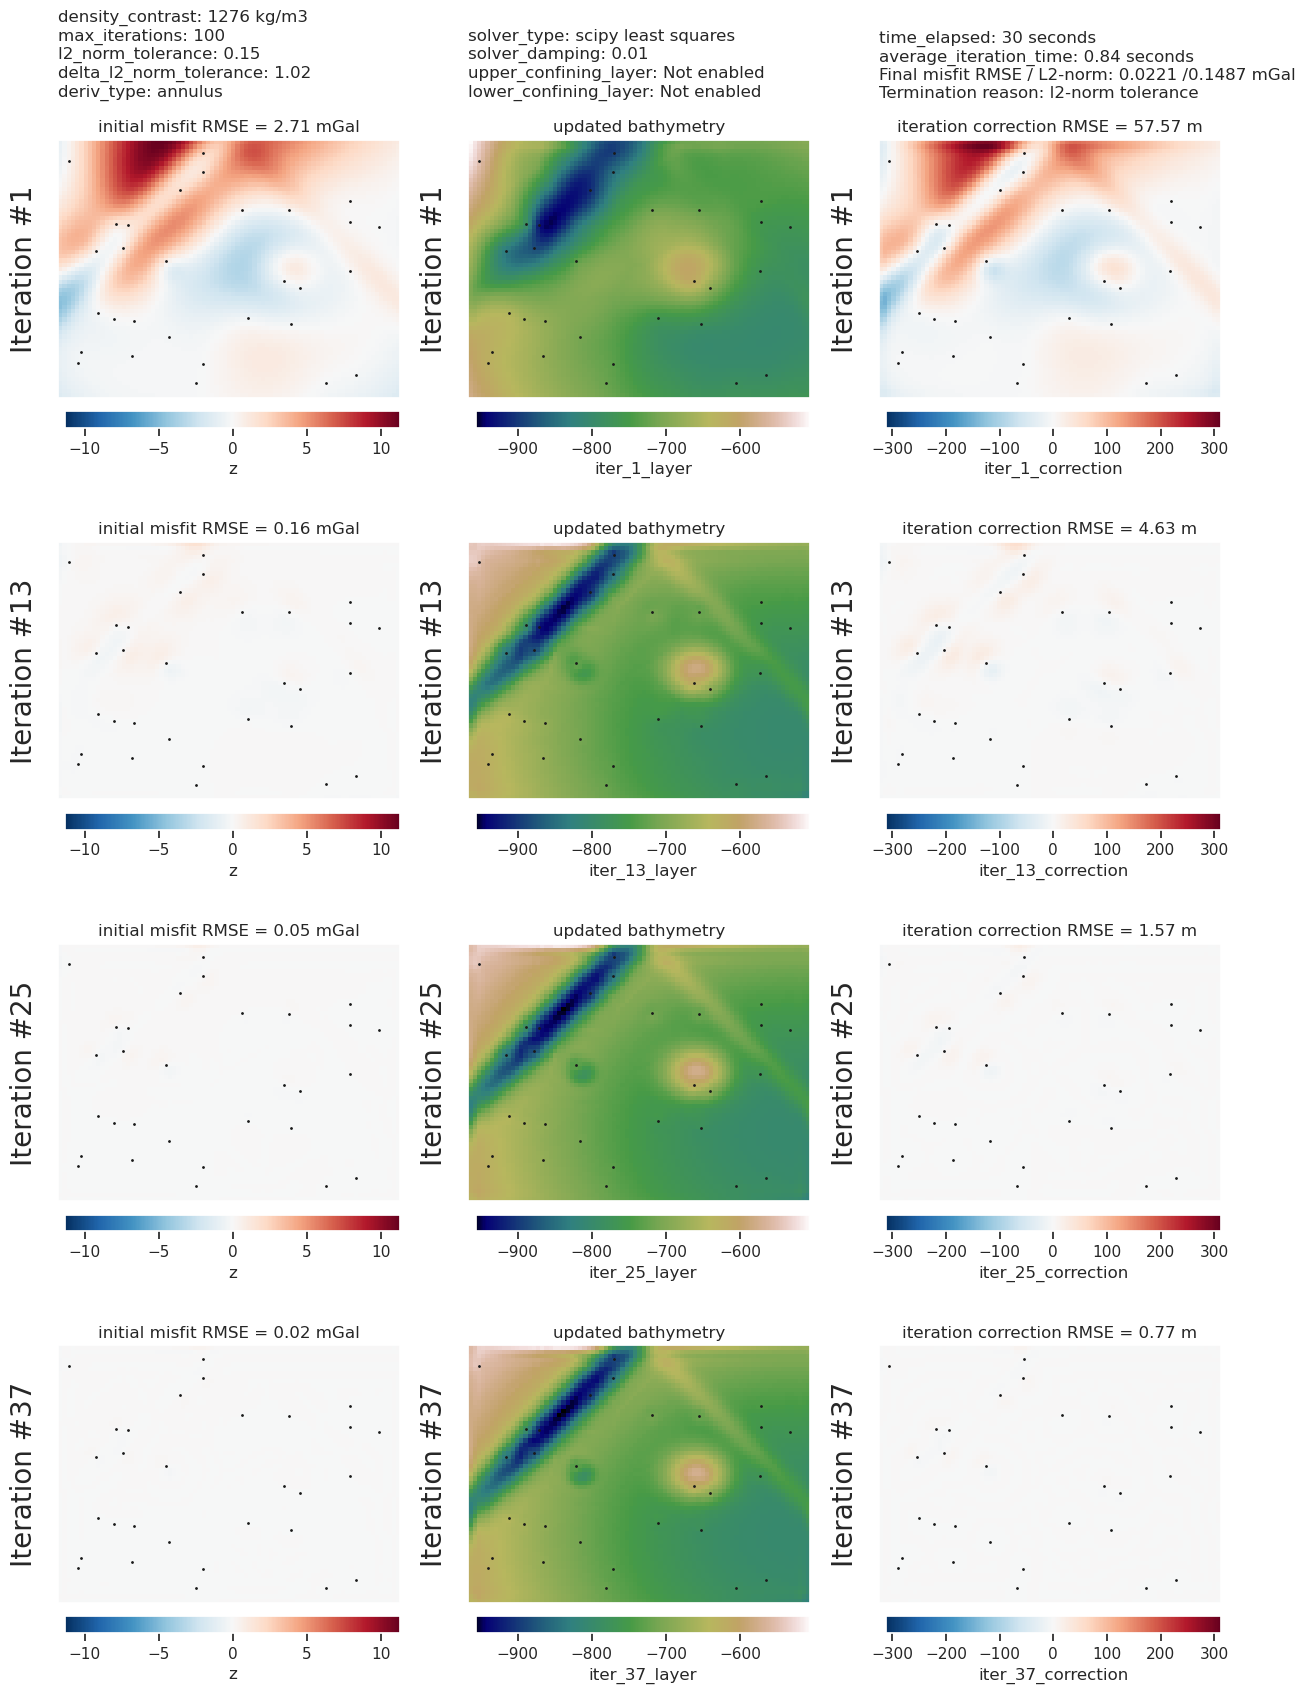

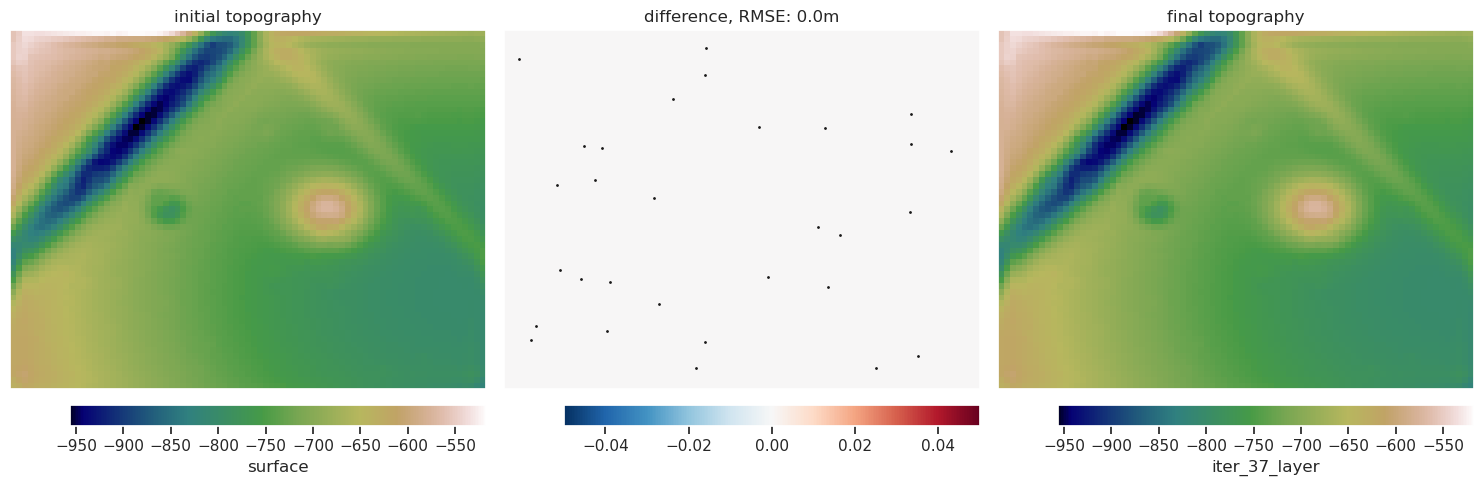

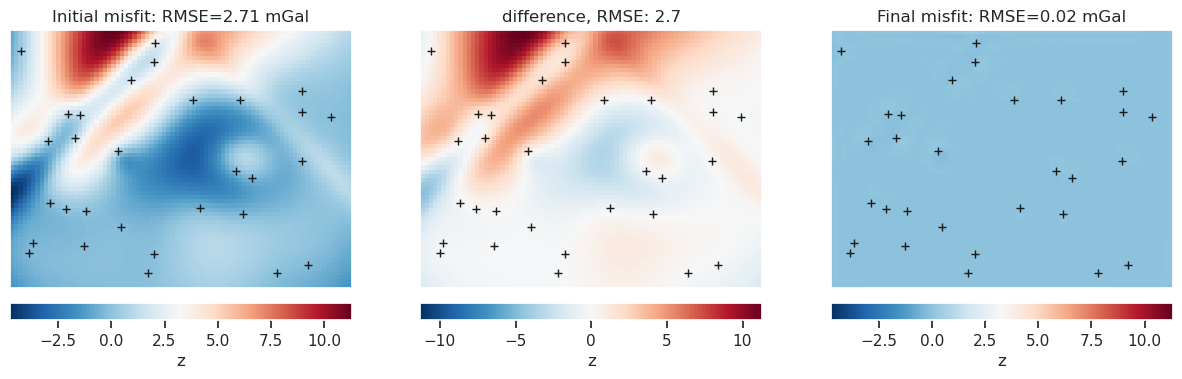

In [17]:
with inv_utils.HiddenPrints():
    _ = inv.inversion_RMSE(
        results=inv_result,
        input_grav=full_res_grav[full_res_grav.test == False],
        inversion_region=inversion_region,
        true_surface=layer1,
        plot=True,
        plot_type="pygmt",
        label_offset="j0c/.2c",
        **kwargs,
    )

plotting.plot_convergence(inv_result[2], iter_times=inv_result[3]["iter_times"])

_ = plotting.plot_inversion_results(
    inv_result[2],
    inv_result[1],
    inv_result[3],
    grav_region=inversion_region,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    iters_to_plot=4,
    grav_spacing=grav_spacing,
    constraints=constraints,
)

print(f"RMSE: {inv_result[0]}")
print(f"constraints RMSE: {inv_result[-1]}")

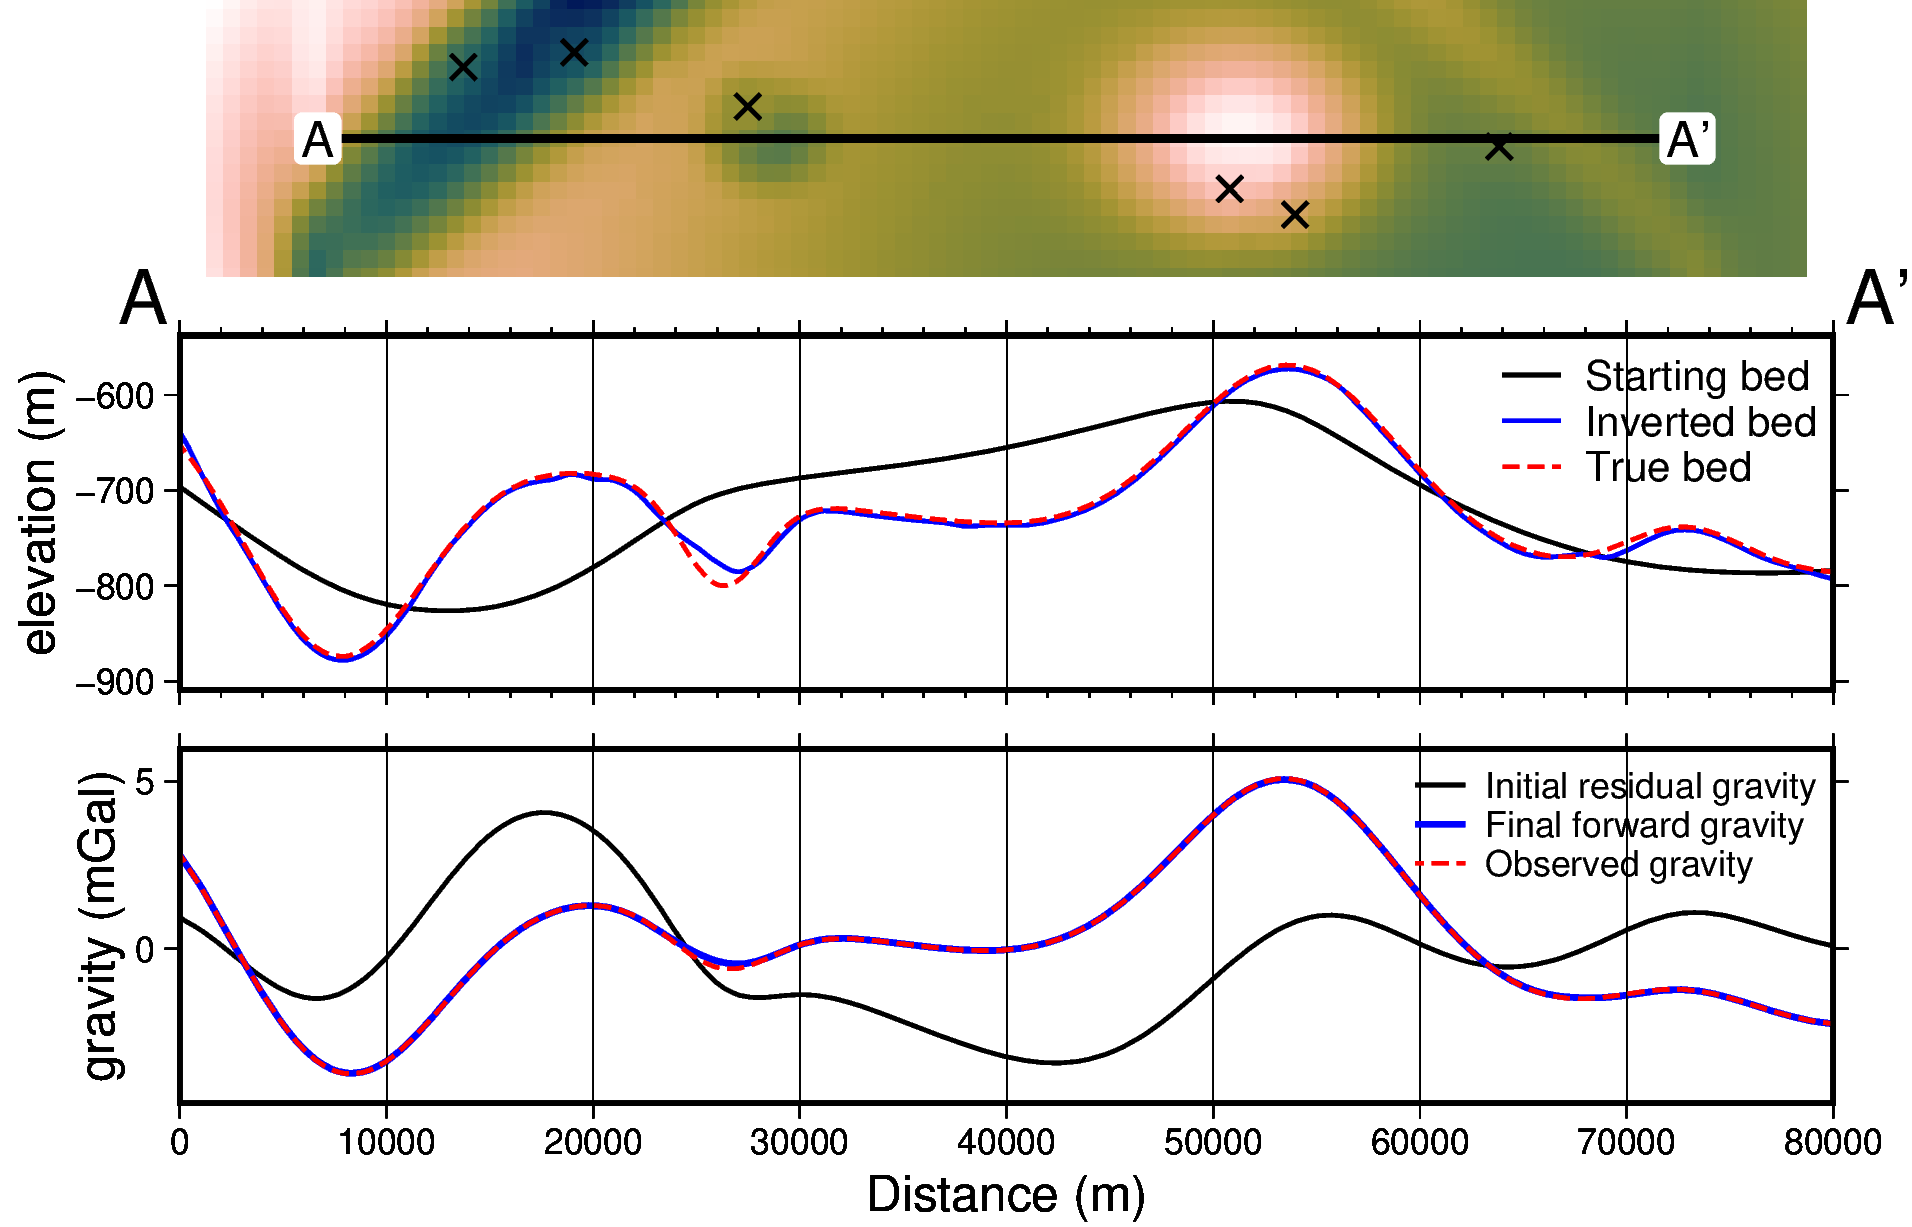

In [18]:
fig = plotting.plot_inversion_results_profile(
    inv_result[1],
    inv_result[2],
    input_forward_column="layer1_forward",
    constraints=constraints,
    true_surface=layer1,
    start=[inversion_region[0], 30e3],
    stop=[inversion_region[1], 30e3],
    map_buffer=0.1,
    subplot_orientation="vertical",
    data_legend_loc="jTR+o0c",
    layers_legend_loc="jTR+o0c",
)
fig.show()

### Repeate with small-prism approximation

Damping values: [0.0001     0.00021544 0.00046416 0.001      0.00215443 0.00464159
 0.01       0.02154435 0.04641589 0.1       ]
Best score: 0.04787825323926315
Best damping: 0.01


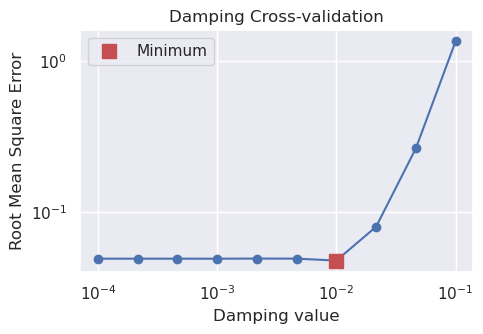

In [19]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist

# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    prism_layer=starting_prisms,
    max_iterations=100,
    l2_norm_tolerance=0.15,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    # deriv_type="annulus",
    deriv_type="prisms",
    solver_type="scipy least squares",
    constraints=constraints,
)

# fname = "../../synthetic_data/synthetic_simple_damping_CV_annulus"
fname = "../../synthetic_data/synthetic_simple_damping_CV_prisms"
dampings = np.logspace(-4, -1, 10)
print(f"Damping values: {dampings}")

scores, rmses = inv.inversion_optimal_parameters(
    training_data=full_res_grav[full_res_grav.test == False],
    testing_data=full_res_grav[full_res_grav.test == True],
    parameter_values=dampings,
    function=inv.inversion_damping_MSE,
    plot=False,
    plot_grids=True,
    results_fname=fname,
    progressbar=True,
    true_surface=layer1,
    inversion_region=inversion_region,
    **kwargs,
)

# put scores and damping values into dict
CV_results = dict(scores=scores, dampings=dampings, rmses=rmses)

# remove if exists
pathlib.Path(fname).unlink(missing_ok=True)

# save scores and dampings to pickle
with open(f"{fname}.pickle", "wb") as f:
    pickle.dump(CV_results, f)

# load scores and dampings from pickle
with open(f"{fname}.pickle", "rb") as f:
    CV_results = pickle.load(f)

best = np.argmin(CV_results["scores"])
print("Best score:", CV_results["scores"][best])
print("Best damping:", CV_results["dampings"][best])

# get best inversion result of each set
with open(f"{fname}_trial_{best}.pickle", "rb") as f:
    inv_result = pickle.load(f)

plotting.plot_parameter_cv(
    CV_results["scores"],
    CV_results["dampings"],
    logx=True,
    logy=True,
    param_name="Damping",
)

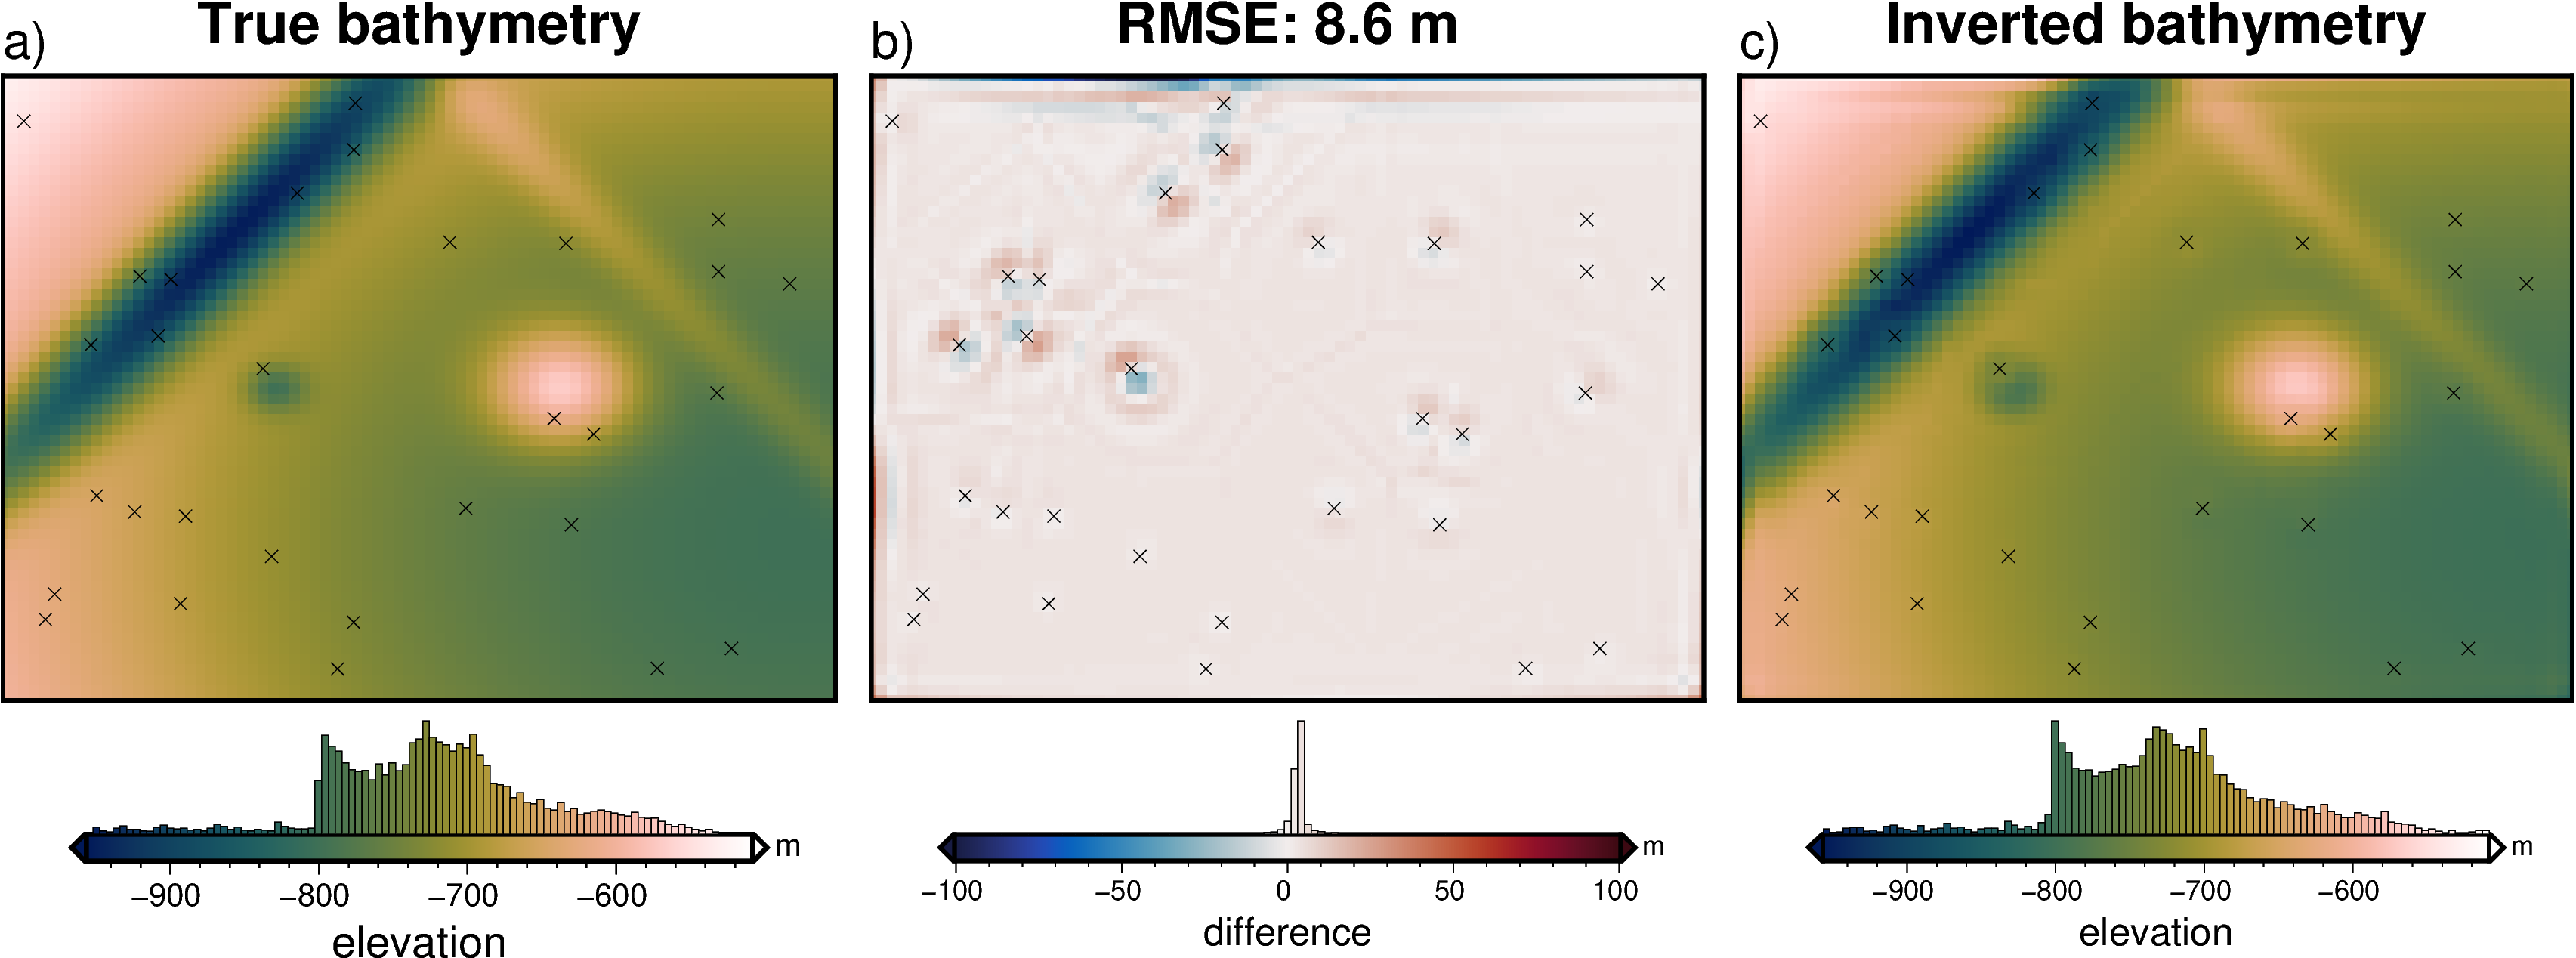

RMSE: 8.572737048843756
constraints RMSE: 1.19


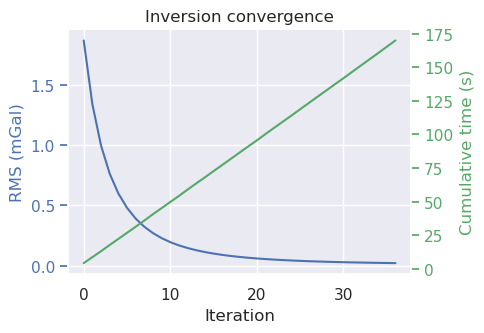

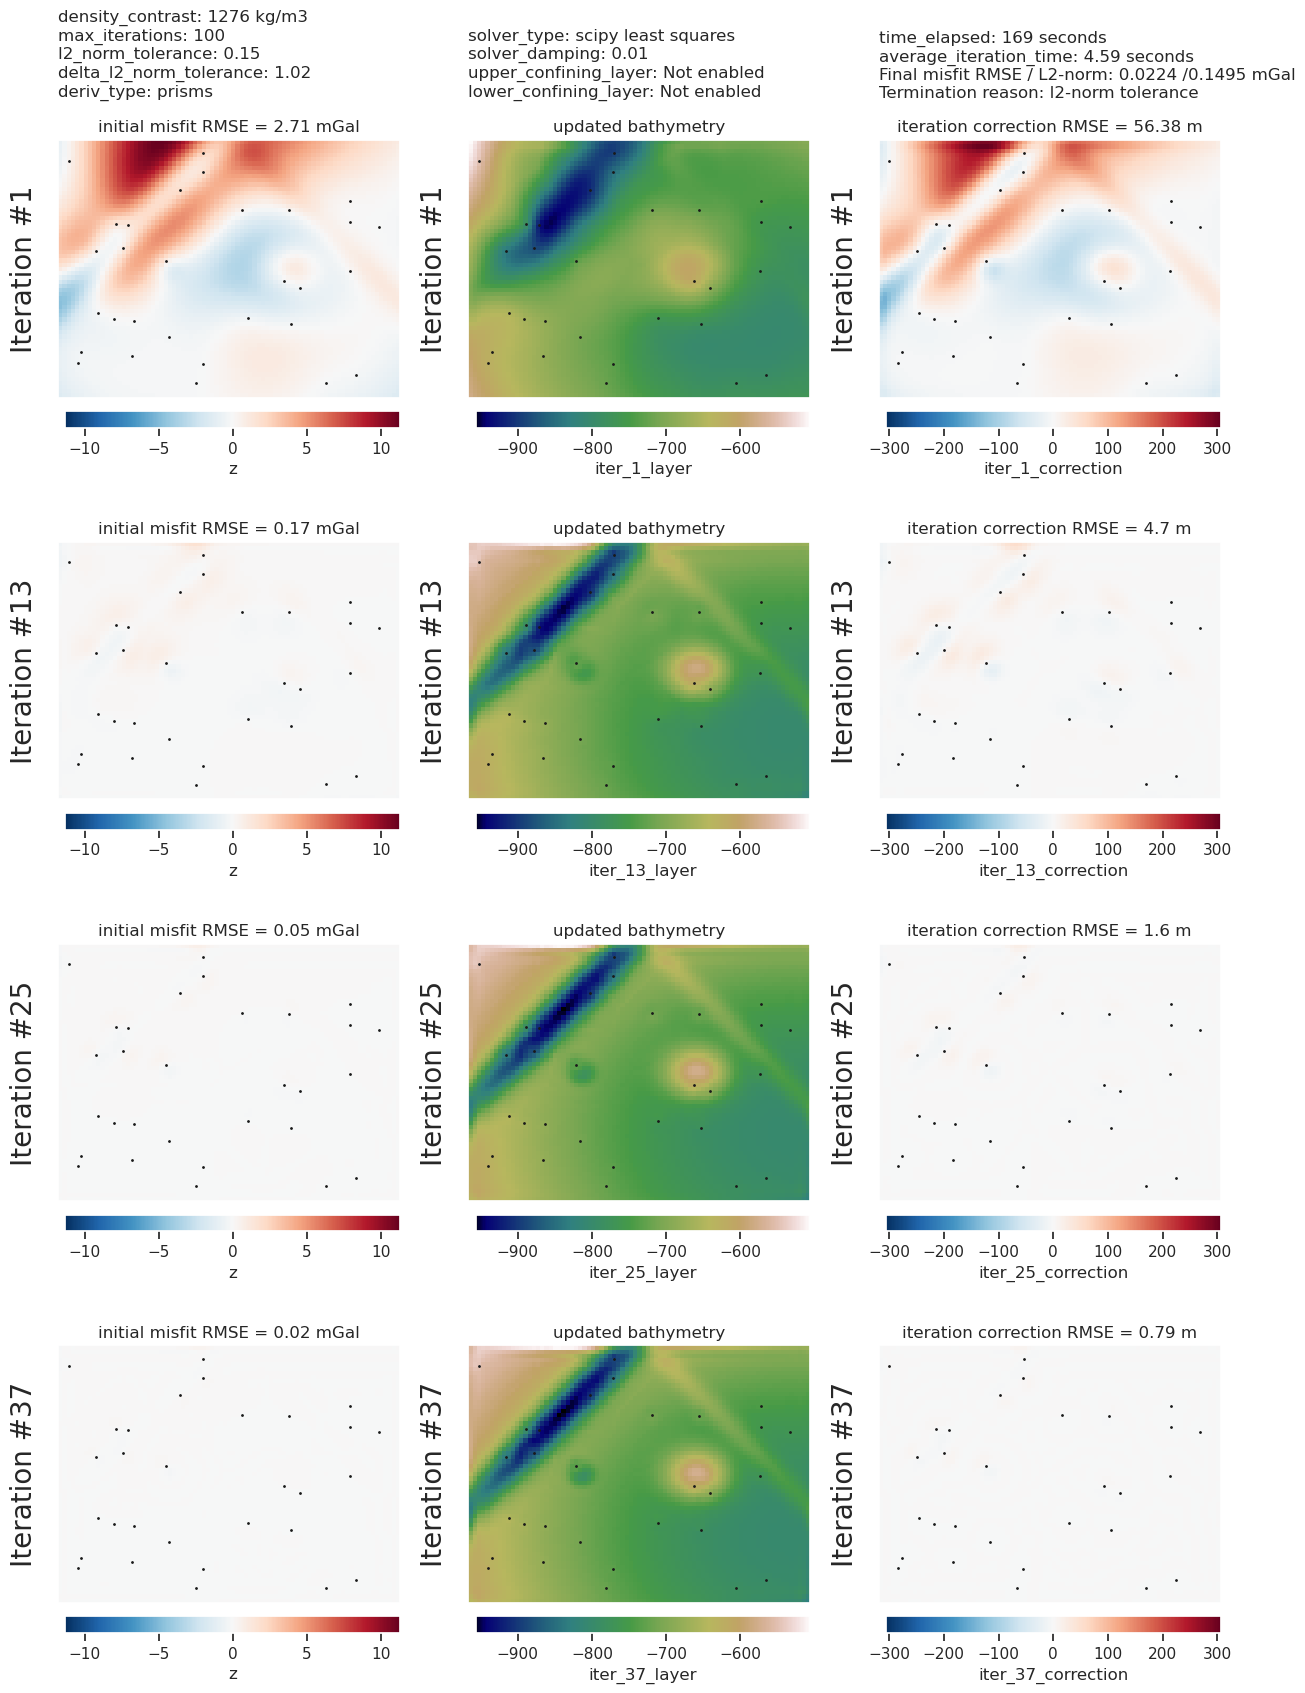

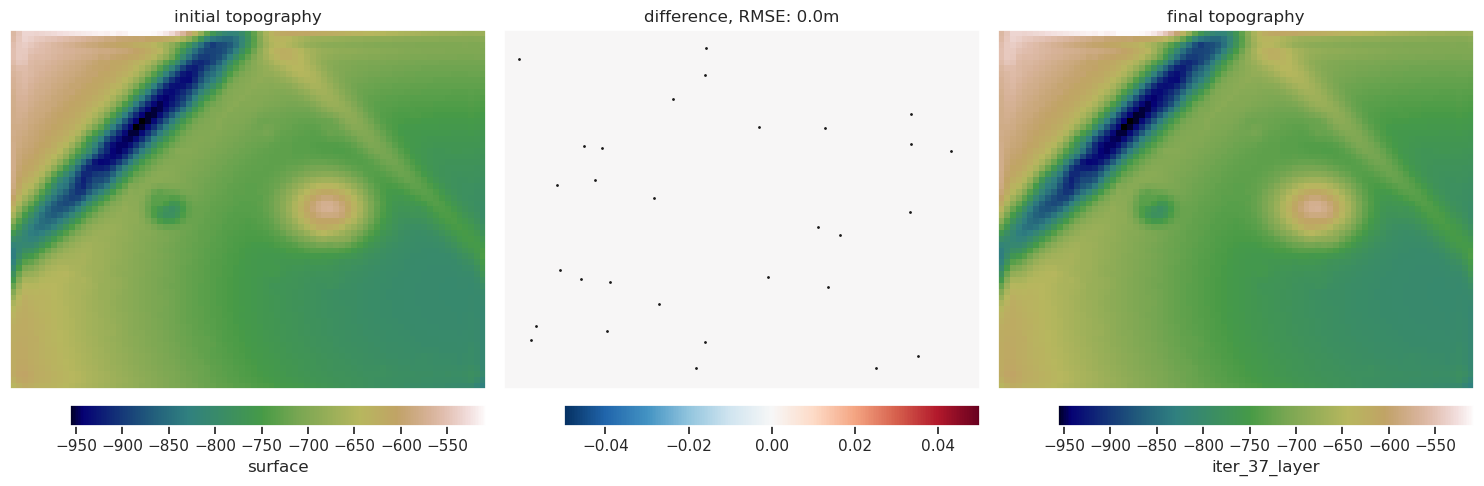

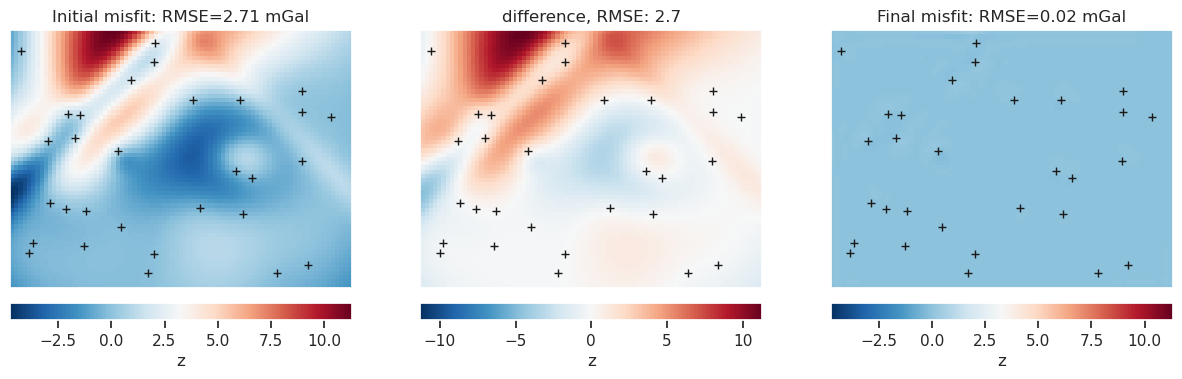

In [20]:
with inv_utils.HiddenPrints():
    _ = inv.inversion_RMSE(
        results=inv_result,
        input_grav=full_res_grav[full_res_grav.test == False],
        inversion_region=inversion_region,
        true_surface=layer1,
        plot=True,
        plot_type="pygmt",
        label_offset="j0c/.2c",
        **kwargs,
    )

plotting.plot_convergence(inv_result[2], iter_times=inv_result[3]["iter_times"])

_ = plotting.plot_inversion_results(
    inv_result[2],
    inv_result[1],
    inv_result[3],
    grav_region=inversion_region,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    iters_to_plot=4,
    grav_spacing=grav_spacing,
    constraints=constraints,
)

print(f"RMSE: {inv_result[0]}")
print(f"constraints RMSE: {inv_result[-1]}")

## Full resolution grav with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [21]:
# contaminate with noise
full_res_grav_noise = full_res_grav.copy()
full_res_grav_noise["Gobs"] = synthetic.contaminate(
    full_res_grav_noise.Gobs,
    stddev=0.02,
    percent=True,
    seed=0,
)
# DC shift and calculate misfit
full_res_grav_noise = inv.misfit(
    input_grav=full_res_grav_noise,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraints,
)
# set regional to 0
full_res_grav_noise["reg"] = 0
full_res_grav_noise["res"] = full_res_grav_noise.misfit

full_res_grav_noise

Standard deviation used for noise: [0.16382499594057567]
DC shifted observed gravity by -1.01mGal to match forward gravity.


northing  easting      Gobs  Surface2  forward_total   test  upward  \
0           0.0      0.0  5.185691 -1.585934       3.310012  False  1000.0   
1           0.0    500.0  4.898845 -1.641775       3.190765   True  1000.0   
2           0.0   1000.0  4.925377 -1.697236       3.067050  False  1000.0   
3           0.0   1500.0  5.059999 -1.752310       2.939826   True  1000.0   
4           0.0   2000.0  4.923527 -1.806994       2.809832  False  1000.0   
...         ...      ...       ...       ...            ...    ...     ...   
19476   60000.0  78000.0  0.638063  8.397605       9.220126  False  1000.0   
19477   60000.0  78500.0  0.922292  8.327652       9.149448   True  1000.0   
19478   60000.0  79000.0  0.892272  8.246703       9.068014  False  1000.0   
19479   60000.0  79500.0  0.965702  8.153546       8.974489   True  1000.0   
19480   60000.0  80000.0  0.989985  8.046806       8.867341  False  1000.0   

       layer1_forward  Gobs_shift    misfit  reg       res  
0            7.336436    6.193178 -1.143257    0 -1.143257  
1            7.196777    5.906332 -1.290444    0 -1.290444  
2            7.053205    5.932865 -1.120340    0 -1.120340  
3            6.907357    6.067486 -0.839871    0 -0.839871  
4            6.760484    5.931015 -0.829469    0 -0.829469  
...               ...         ...       ...  ...       ...  
19476        0.539365    1.645550  1.106185    0  1.106185  
19477        0.610158    1.929780  1.319622    0  1.319622  
19478        0.680730    1.899759  1.219029    0  1.219029  
19479        0.750859    1.973189  1.222330    0  1.222330  
19480        0.820233    1.997473  1.177239    0  1.177239  

[19481 rows x 12 columns]

In [49]:
# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=100,
#     l2_norm_tolerance=0.4,
#     delta_l2_norm_tolerance=1.02, # stop if l2-norm doesnt decrease by at least 1%
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     # deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 0.01,
#     plot_convergence=True,
# )

# with inv_utils.HiddenPrints():
#     results = inv.inversion_RMSE(
#         input_grav=full_res_grav_noise[full_res_grav_noise.test==False],
#         inversion_region=inversion_region,
#         true_surface = layer1,
#         constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#         plot=True,
#         plot_type="xarray",
#         **kwargs,
#     )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

### Optimize only for damping

Best score: 0.19407079023941393
Best damping: 0.01


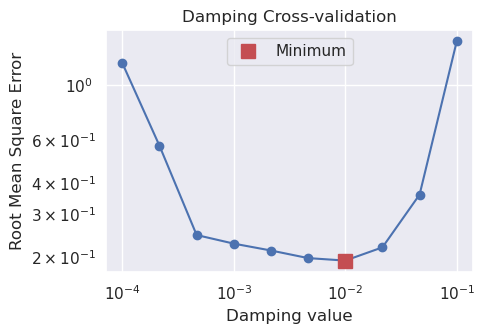

In [22]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist

# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    prism_layer=starting_prisms,
    max_iterations=100,
    l2_norm_tolerance=0.4,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    # deriv_type = "prisms",
    solver_type="scipy least squares",
    constraints=constraints,
)

fname = "../../synthetic_data/synthetic_simple_noise_damping_CV"
dampings = np.logspace(-4, -1, 10)
# print(f"Damping values: {dampings}")

scores, rmses = inv.inversion_optimal_parameters(
    training_data=full_res_grav_noise[full_res_grav_noise.test == False],
    testing_data=full_res_grav_noise[full_res_grav_noise.test == True],
    parameter_values=dampings,
    function=inv.inversion_damping_MSE,
    plot=False,
    plot_grids=True,
    results_fname=fname,
    progressbar=True,
    true_surface=layer1,
    inversion_region=inversion_region,
    **kwargs,
)

# put scores and damping values into dict
CV_results = dict(scores=scores, dampings=dampings, rmses=rmses)

# remove if exists
pathlib.Path(fname).unlink(missing_ok=True)

# save scores and dampings to pickle
with open(f"{fname}.pickle", "wb") as f:
    pickle.dump(CV_results, f)

# load scores and dampings from pickle
with open(f"{fname}.pickle", "rb") as f:
    CV_results = pickle.load(f)

best = np.argmin(CV_results["scores"])
print("Best score:", CV_results["scores"][best])
print("Best damping:", CV_results["dampings"][best])

# get best inversion result of each set
with open(f"{fname}_trial_{best}.pickle", "rb") as f:
    inv_result = pickle.load(f)

plotting.plot_parameter_cv(
    CV_results["scores"],
    CV_results["dampings"],
    logx=True,
    logy=True,
    param_name="Damping",
)

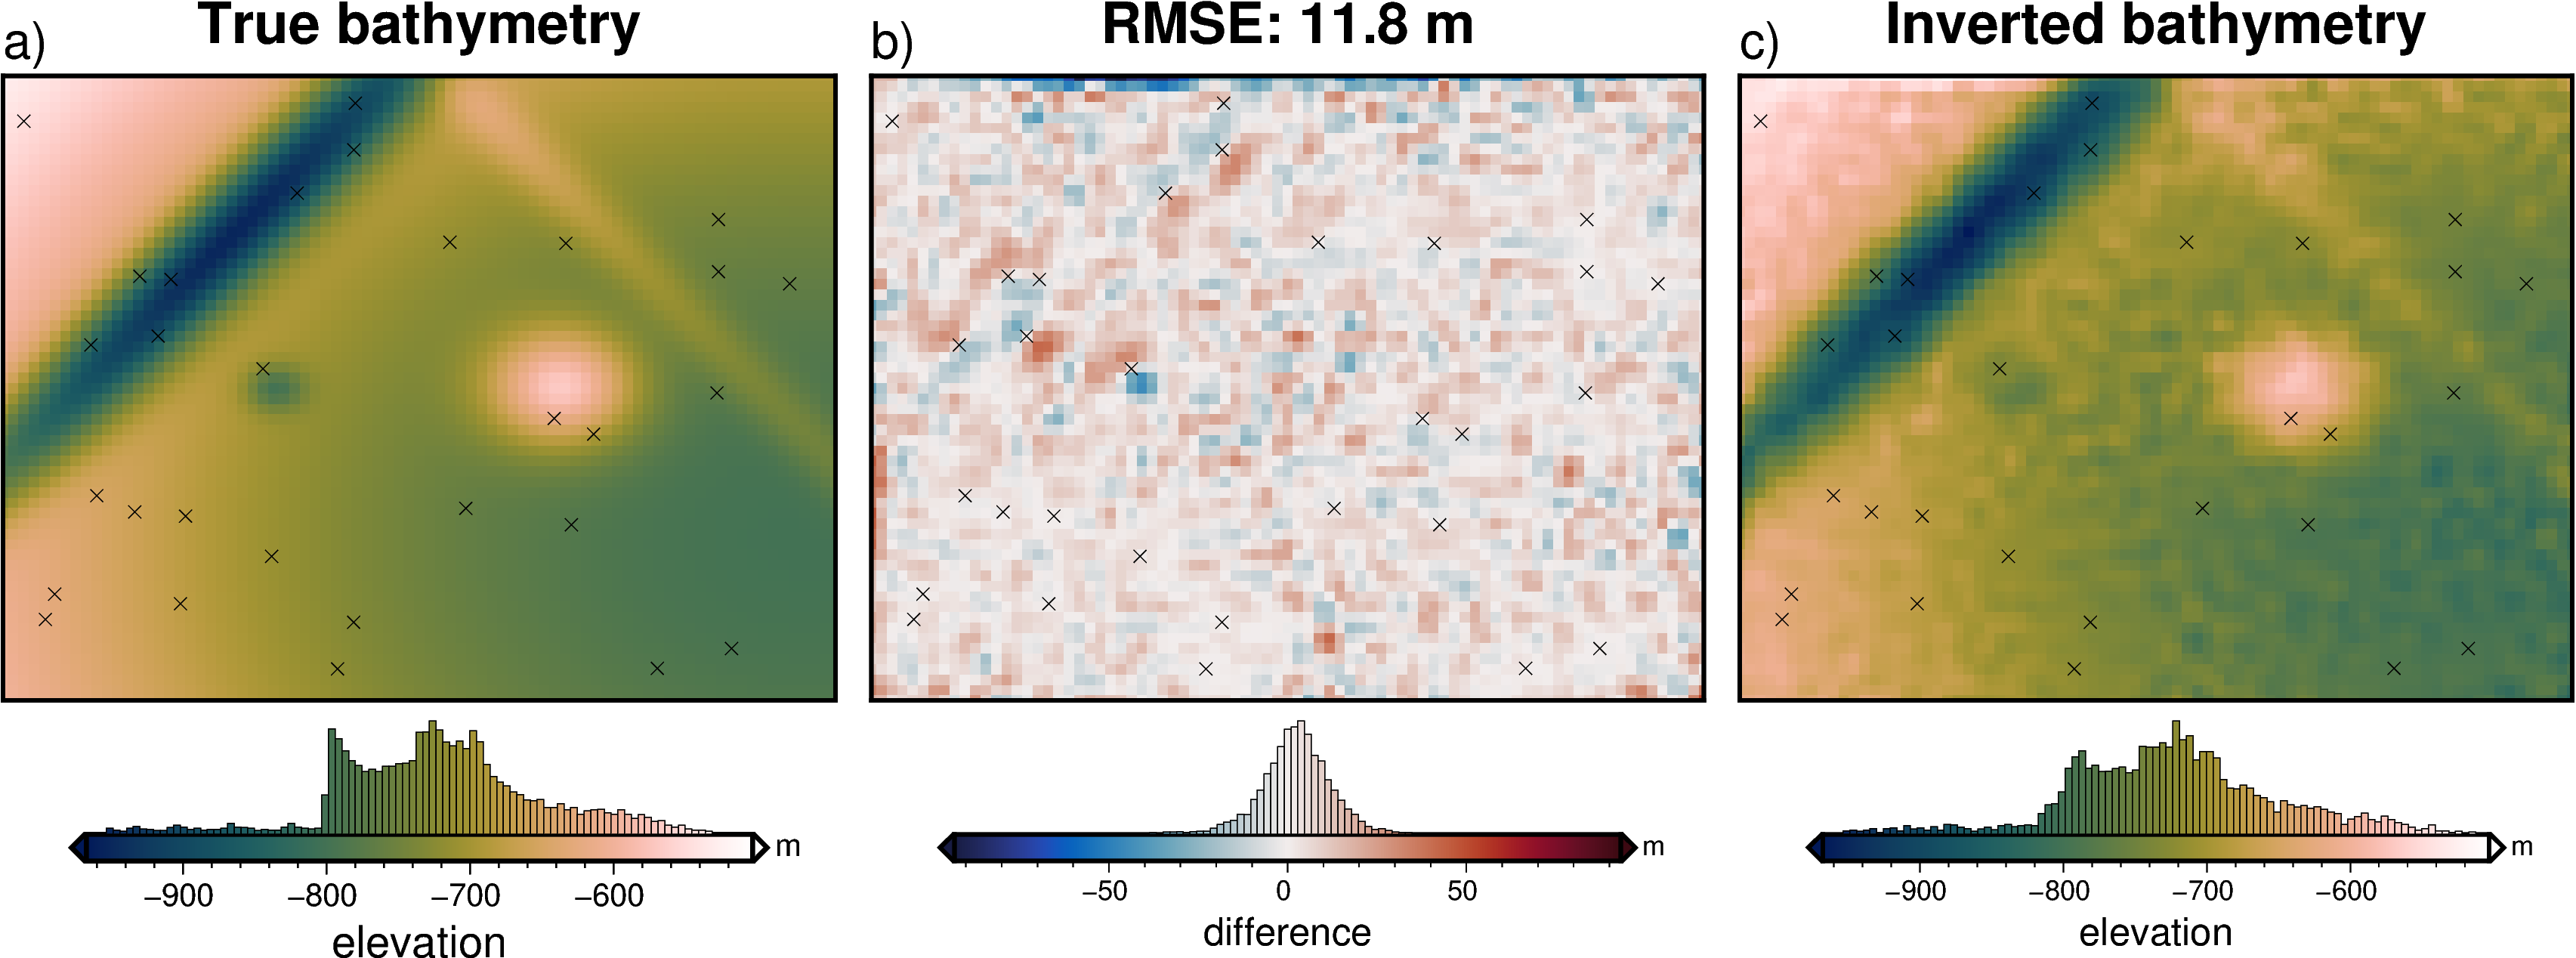

RMSE: 11.802197765126058
constraints RMSE: 0.87


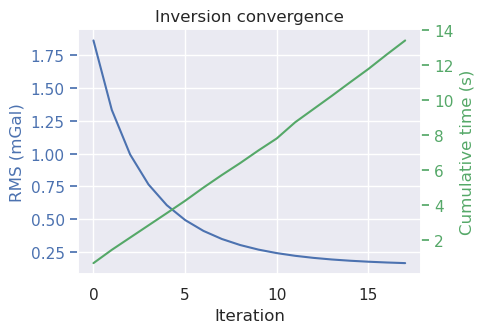

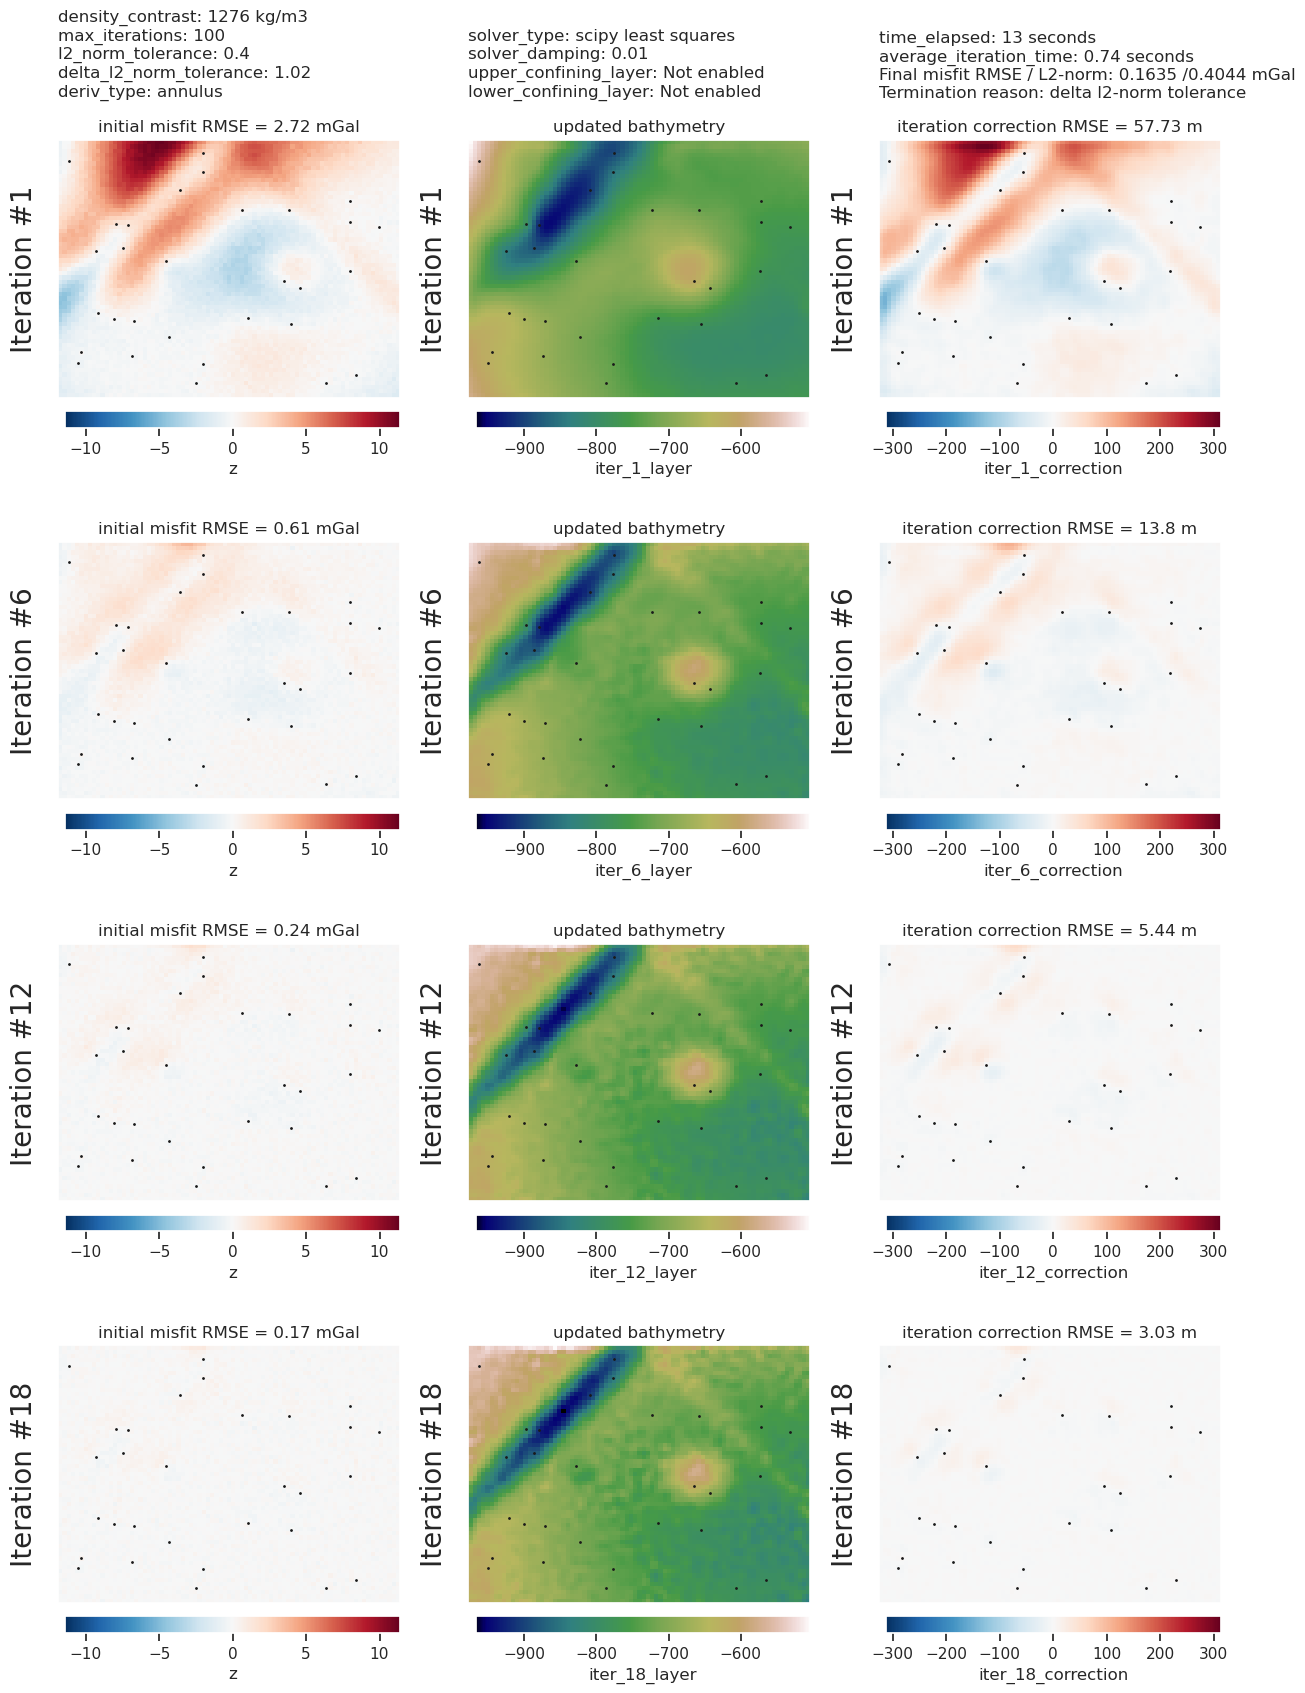

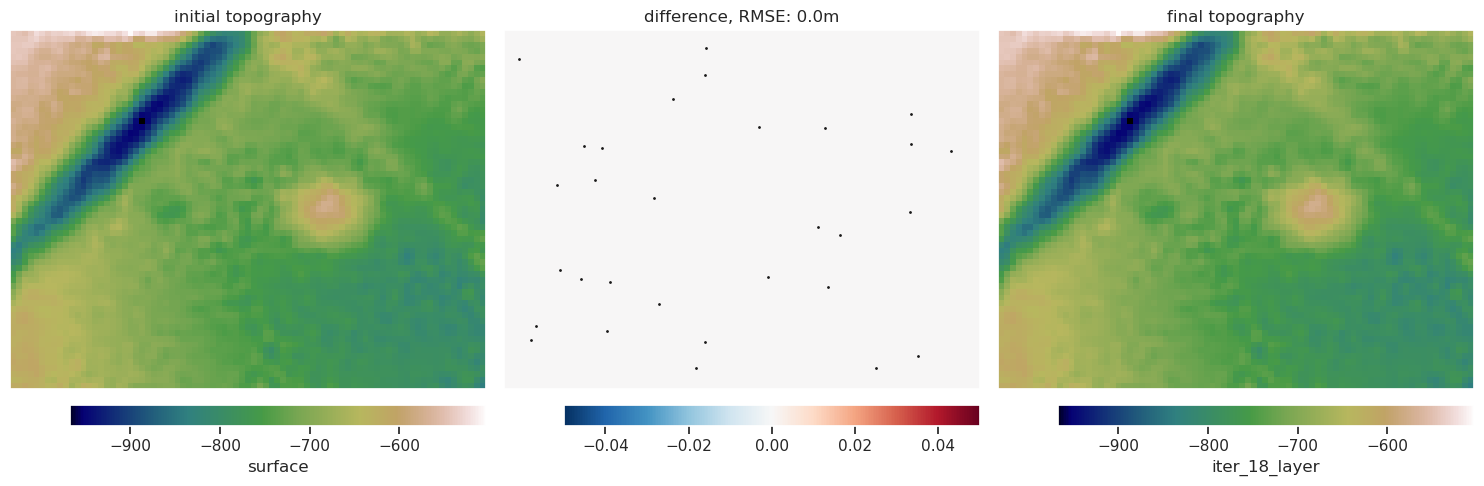

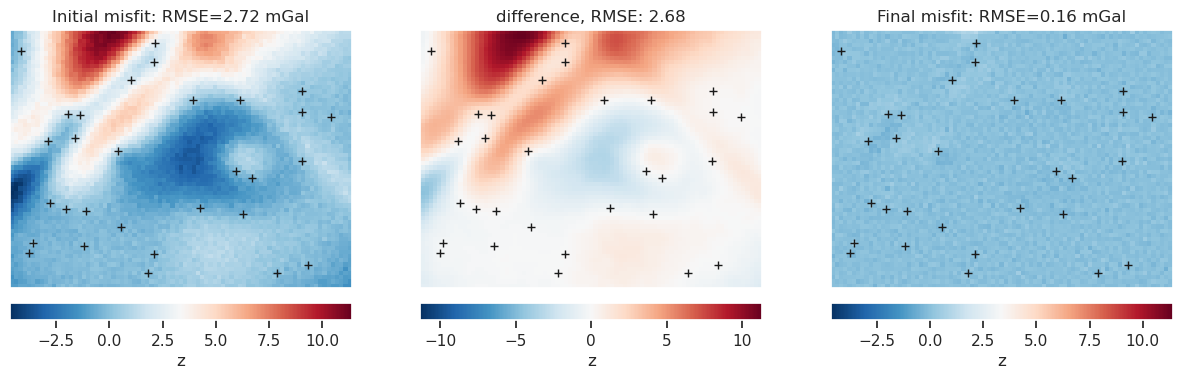

In [23]:
with inv_utils.HiddenPrints():
    _ = inv.inversion_RMSE(
        results=inv_result,
        input_grav=full_res_grav_noise[full_res_grav_noise.test == False],
        inversion_region=inversion_region,
        true_surface=layer1,
        plot=True,
        plot_type="pygmt",
        label_offset="j0c/.2c",
        **kwargs,
    )

plotting.plot_convergence(inv_result[2], iter_times=inv_result[3]["iter_times"])

_ = plotting.plot_inversion_results(
    inv_result[2],
    inv_result[1],
    inv_result[3],
    grav_region=inversion_region,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    iters_to_plot=4,
    grav_spacing=grav_spacing,
    constraints=constraints,
)

print(f"RMSE: {inv_result[0]}")
print(f"constraints RMSE: {inv_result[-1]}")

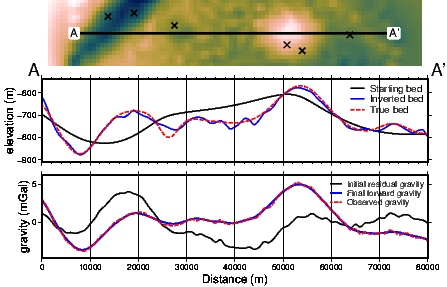

In [24]:
plotting.plot_inversion_results_profile(
    inv_result[1],
    inv_result[2],
    input_forward_column="layer1_forward",
    constraints=constraints,
    true_surface=layer1,
    start=[inversion_region[0], 30e3],
    stop=[inversion_region[1], 30e3],
    map_buffer=0.1,
    subplot_orientation="vertical",
    data_legend_loc="jTR+o0c",
    layers_legend_loc="jTR+o0c",
)

## Sampled grav, no noise

[1e-10, 3.3598182862837877e-10, 1.1288378916846883e-09, 3.792690190732254e-09, 1.274274985703132e-08, 4.281332398719396e-08, 1.438449888287663e-07, 4.832930238571752e-07, 1.6237767391887209e-06, 5.455594781168514e-06, 1.8329807108324338e-05, 6.158482110660255e-05, 0.00020691380811147902, 0.0006951927961775605, 0.002335721469090121, 0.007847599703514606, 0.026366508987303555, 0.08858667904100832, 0.2976351441631313, 1.0]
[ 5000.          5789.47368421  6578.94736842  7368.42105263
  8157.89473684  8947.36842105  9736.84210526 10526.31578947
 11315.78947368 12105.26315789 12894.73684211 13684.21052632
 14473.68421053 15263.15789474 16052.63157895 16842.10526316
 17631.57894737 18421.05263158 19210.52631579 20000.        ]


Parameters:   0%|          | 0/400 [00:00<?, ?it/s]

Best score: 0.9263471755545707
Best parameters: {'damping': 0.0006951927961775605, 'depth': 11315.78947368421}
14540
4941
DC shifted observed gravity by -0.99mGal to match forward gravity.


northing  easting   test      Gobs  upward  layer1_forward  Gobs_shift  \
0           0.0      0.0  False  4.890486  1000.0        7.336436    5.882001   
1           0.0    500.0   True  4.852125  1000.0        7.196777    5.843640   
2           0.0   1000.0  False  4.803396  1000.0        7.053205    5.794911   
3           0.0   1500.0   True  4.744991  1000.0        6.907357    5.736506   
4           0.0   2000.0  False  4.677790  1000.0        6.760484    5.669305   
...         ...      ...    ...       ...     ...             ...         ...   
19476   60000.0  78000.0  False  0.798884  1000.0        0.539365    1.790399   
19477   60000.0  78500.0   True  0.779639  1000.0        0.610158    1.771154   
19478   60000.0  79000.0  False  0.757911  1000.0        0.680730    1.749426   
19479   60000.0  79500.0   True  0.733863  1000.0        0.750859    1.725378   
19480   60000.0  80000.0  False  0.707717  1000.0        0.820233    1.699232   

         misfit  reg       res  
0     -1.454435    0 -1.454435  
1     -1.353137    0 -1.353137  
2     -1.258293    0 -1.258293  
3     -1.170851    0 -1.170851  
4     -1.091179    0 -1.091179  
...         ...  ...       ...  
19476  1.251034    0  1.251034  
19477  1.160996    0  1.160996  
19478  1.068696    0  1.068696  
19479  0.974519    0  0.974519  
19480  0.878999    0  0.878999  

[19481 rows x 10 columns]

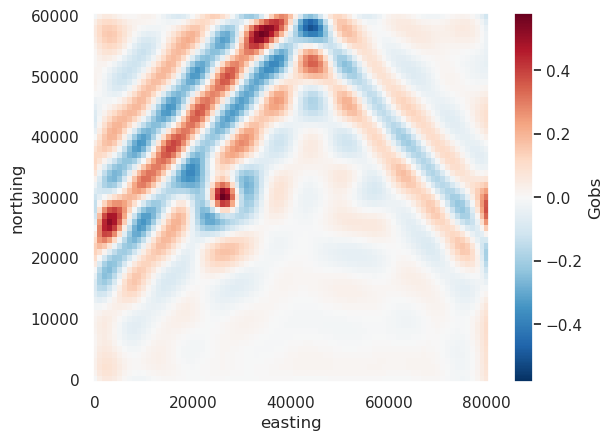

In [26]:
num = 20
dampings = list(np.logspace(-10, 0, num=num))
depths = np.linspace(5e3, 20e3, num)

# dampings = [10**-10, 1]
# depths = [1, 100e3]

sampled_spacing = 6e3
# sample gravity at low resolution grid, regrid at full res with eq sources
sampled_grav, score = inv_utils.resample_gravity_with_test_points(
    grav_df=full_res_grav,
    grav_column="Gobs",
    coord_columns=["easting", "northing", "upward"],
    starting_training_spacing=layer_spacing,
    coarse_training_spacing=sampled_spacing,
    region=inversion_region,
    dampings=dampings,
    depths=depths,
    optimization=False,
    # optimization = True,
    n_trials=20,
    plot=True,
)
print(len(sampled_grav[sampled_grav.test]))
print(len(sampled_grav[sampled_grav.test == False]))

# add layer1 starting forward grav into df
sampled_grav["layer1_forward"] = full_res_grav.layer1_forward

# # contaminate with noise
# sampled_grav["Gobs"] = synthetic.contaminate(
#     sampled_grav.Gobs,
#     stddev=0.04,
#     percent=True,
#     seed=0,
# )

# recalculate misfit
sampled_grav = inv.misfit(
    input_grav=sampled_grav,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs",
    constraints=constraints,
)

# set regional to 0
sampled_grav["reg"] = 0
sampled_grav["res"] = sampled_grav.misfit
sampled_grav

### Save and load results

In [27]:
sampled_grav.to_csv(
    "../../synthetic_data/synthetic_simple_sampled_grav.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

In [28]:
sampled_grav = pd.read_csv(
    "../../synthetic_data/synthetic_simple_sampled_grav.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

sampled_grav

northing  easting   test      Gobs  upward  layer1_forward  Gobs_shift  \
0           0.0      0.0  False  4.890486  1000.0        7.336436    5.882001   
1           0.0    500.0   True  4.852125  1000.0        7.196777    5.843640   
2           0.0   1000.0  False  4.803396  1000.0        7.053205    5.794911   
3           0.0   1500.0   True  4.744991  1000.0        6.907357    5.736506   
4           0.0   2000.0  False  4.677790  1000.0        6.760484    5.669305   
...         ...      ...    ...       ...     ...             ...         ...   
19476   60000.0  78000.0  False  0.798884  1000.0        0.539365    1.790399   
19477   60000.0  78500.0   True  0.779639  1000.0        0.610158    1.771154   
19478   60000.0  79000.0  False  0.757911  1000.0        0.680730    1.749426   
19479   60000.0  79500.0   True  0.733863  1000.0        0.750859    1.725378   
19480   60000.0  80000.0  False  0.707717  1000.0        0.820233    1.699232   

         misfit  reg       res  
0     -1.454435    0 -1.454435  
1     -1.353137    0 -1.353137  
2     -1.258293    0 -1.258293  
3     -1.170851    0 -1.170851  
4     -1.091179    0 -1.091179  
...         ...  ...       ...  
19476  1.251034    0  1.251034  
19477  1.160996    0  1.160996  
19478  1.068696    0  1.068696  
19479  0.974519    0  0.974519  
19480  0.878999    0  0.878999  

[19481 rows x 10 columns]

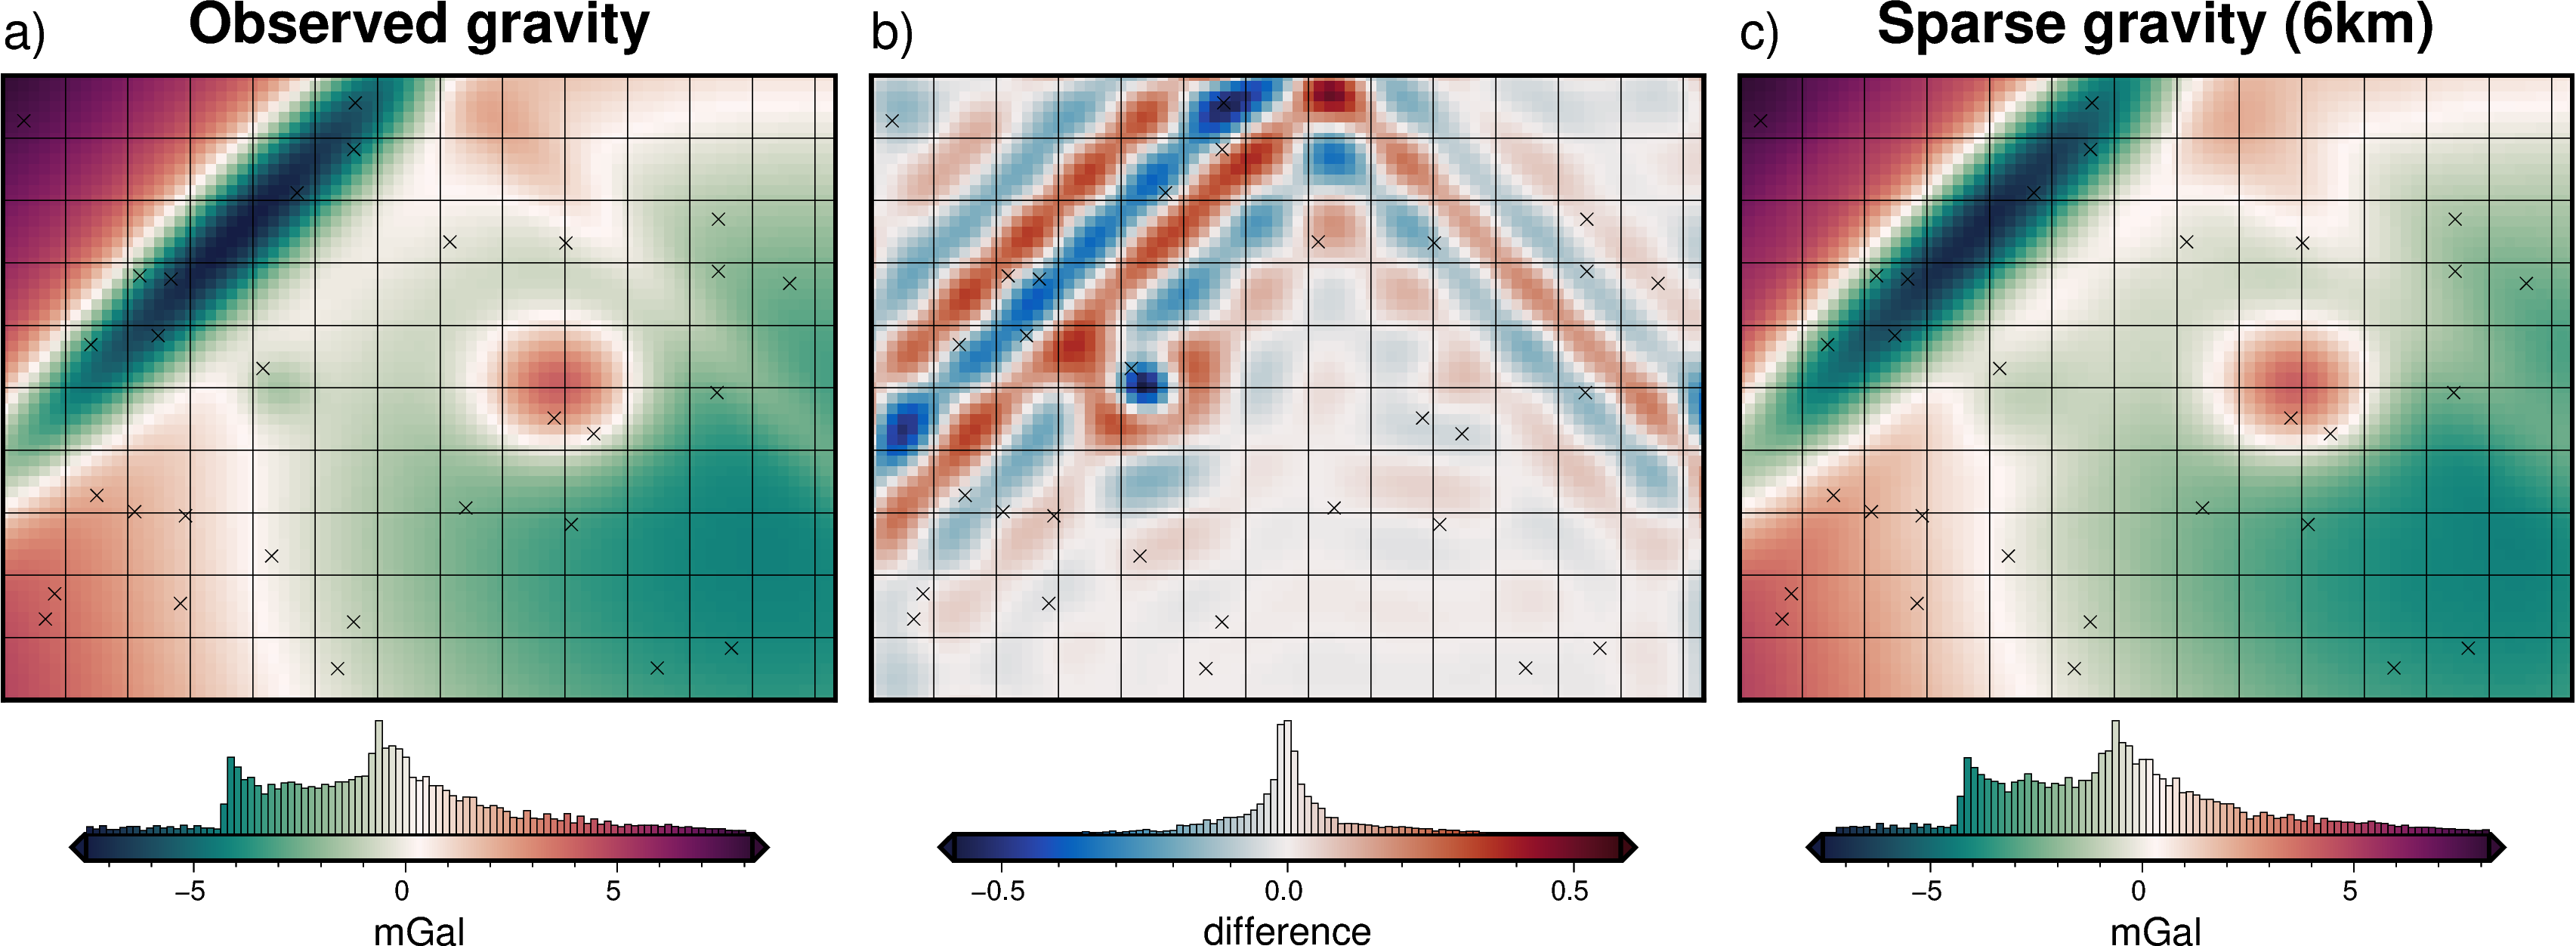

In [29]:
full_grav = (
    full_res_grav[full_res_grav.test == False]
    .set_index(["northing", "easting"])
    .to_xarray()
    .Gobs
)
sampled = (
    sampled_grav[sampled_grav.test == False]
    .set_index(["northing", "easting"])
    .to_xarray()
    .Gobs
)

_ = utils.grd_compare(
    full_grav,
    sampled,
    fig_height=7,
    grid1_name="Observed gravity",
    grid2_name=f"Sparse gravity ({int(sampled_spacing/1e3)}km)",
    title="",
    title_font="18p,Helvetica-Bold,black",
    rmse_in_title=False,  # True,
    cbar_label="mGal",
    plot=True,
    points=constraints.rename(columns={"easting": "x", "northing": "y"}),
    plot_type="pygmt",
    cmap="curl",
    diff_cmap="balance+h0",
    hist=True,
    cbar_yoffset=1.5,
    inset=False,
    points_style="x.2c",
    points_pen=None,
    subplot_labels=True,
    label_font="16p,Helvetica,black",
    robust=False,
    frame=["weSn", f"g{sampled_spacing}"],
)

In [30]:
# change spacing and resample at each new point
sampled_grav_no_eq = inv_utils.resample_with_test_points(
    sampled_spacing,  # training spacing
    full_res_grav,
    inversion_region,
)

print(len(sampled_grav_no_eq[sampled_grav_no_eq.test]))
print(len(sampled_grav_no_eq[sampled_grav_no_eq.test == False]))
sampled_grav_no_eq

434
154


northing       easting   test      Gobs  Surface2  forward_total  upward  \
0         0.0      0.000000  False  4.895946 -1.585934       3.310012  1000.0   
1         0.0   2962.962963   True  4.464934 -1.911220       2.553715  1000.0   
2         0.0   5925.925926  False  3.964539 -2.223246       1.741292  1000.0   
3         0.0   8888.888889   True  3.443497 -2.523306       0.920191  1000.0   
4         0.0  11851.851852  False  2.919775 -2.812786       0.106989  1000.0   
..        ...           ...    ...       ...       ...            ...     ...   
583   60000.0  68148.148148   True  0.952427  8.494065       9.446492  1000.0   
584   60000.0  71111.111111  False  0.886146  8.641297       9.527444  1000.0   
585   60000.0  74074.074074   True  0.844336  8.664099       9.508435  1000.0   
586   60000.0  77037.037037  False  0.824922  8.505170       9.330092  1000.0   
587   60000.0  80000.000000   True  0.820536  8.046805       8.867341  1000.0   

     layer1_forward  Gobs_shift    misfit  
0          7.336436    5.870426 -1.466010  
1          6.478156    5.439415 -1.038742  
2          5.649265    4.939018 -0.710247  
3          4.907733    4.417977 -0.489756  
4          4.244597    3.894255 -0.350342  
..              ...         ...       ...  
583       -0.853413    1.926907  2.780320  
584       -0.429629    1.860626  2.290255  
585       -0.014051    1.818816  1.832867  
586        0.402934    1.799402  1.396468  
587        0.820233    1.795015  0.974782  

[588 rows x 10 columns]

In [31]:
dampings = list(np.logspace(-10, -5, num=9))
dampings.append(None)

mindists = list(np.linspace(1, 1e3, 10))

df = sampled_grav_no_eq[sampled_grav_no_eq.test == False]

coords = (df.easting, df.northing, df.upward)

spline = inv_utils.best_SplineCV(
    coordinates=coords,
    data=df.Gobs,
    dampings=dampings,
    mindists=mindists,
    # delayed=True,
)

sampled_no_eq_grid = spline.grid(region=inversion_region, spacing=layer_spacing).scalars

Highest score: 0.9215722032484372
Best damping: None


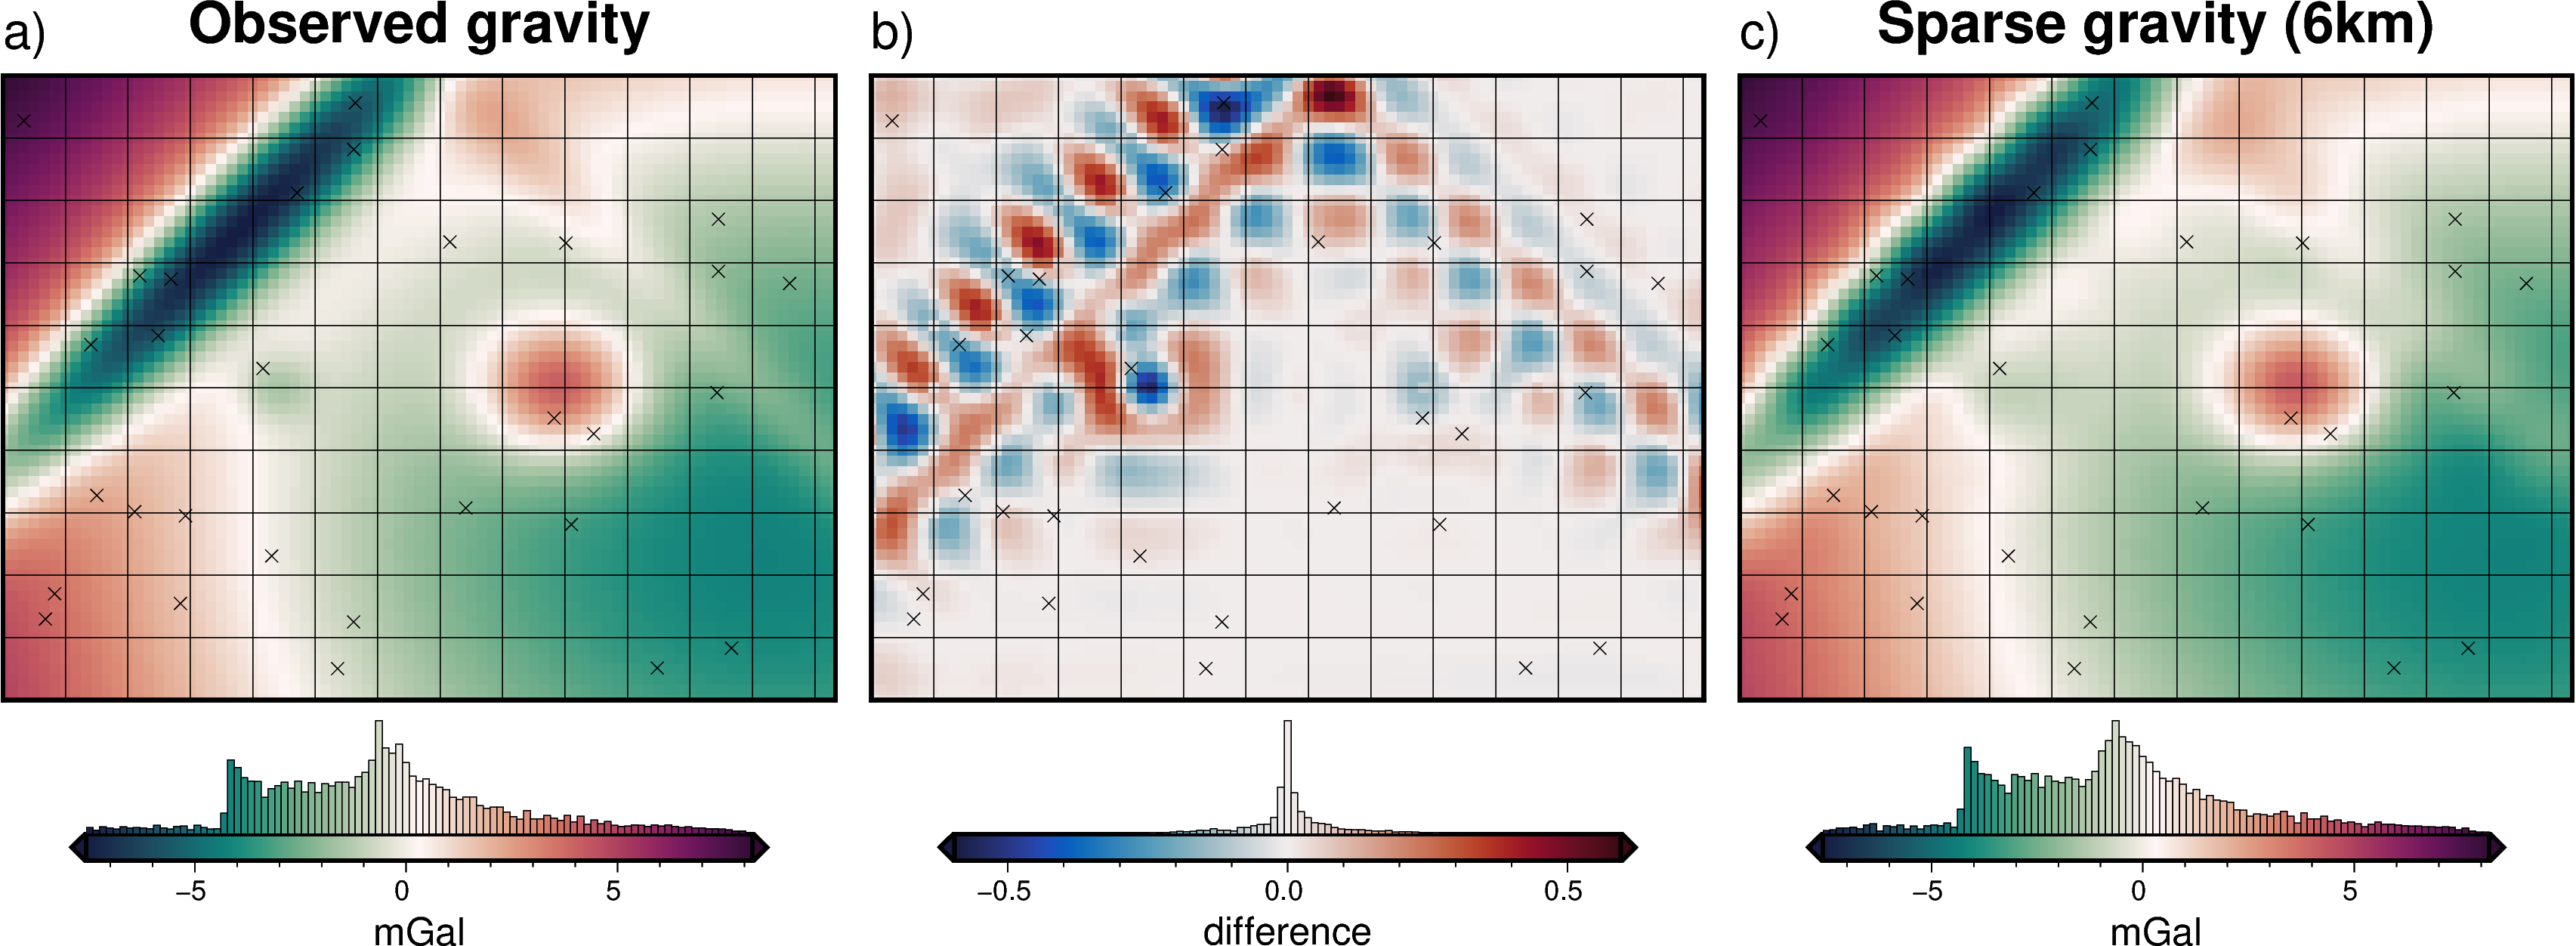

In [32]:
full_grav = (
    full_res_grav[full_res_grav.test == False]
    .set_index(["northing", "easting"])
    .to_xarray()
    .Gobs
)

_ = utils.grd_compare(
    full_grav,
    sampled_no_eq_grid,
    fig_height=7,
    grid1_name="Observed gravity",
    grid2_name=f"Sparse gravity ({int(sampled_spacing/1e3)}km)",
    title="",
    title_font="18p,Helvetica-Bold,black",
    rmse_in_title=False,  # True,
    cbar_label="mGal",
    plot=True,
    points=constraints.rename(columns={"easting": "x", "northing": "y"}),
    plot_type="pygmt",
    cmap="curl",
    diff_cmap="balance+h0",
    hist=True,
    cbar_yoffset=1.5,
    inset=False,
    points_style="x.2c",
    points_pen=None,
    subplot_labels=True,
    label_font="16p,Helvetica,black",
    robust=False,
    frame=["weSn", f"g{sampled_spacing}"],
)

In [57]:
# starting_prisms = copy.deepcopy(layer1_prisms)

# min_dist = inv_utils.normalized_mindist(
#     constraints,
#     starting_prisms,
#     mindist = layer_spacing/np.sqrt(2),
#     low = 0,
#     high = 1,
#     # region=inversion_region,
# )
# starting_prisms["weights"] = min_dist

# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=100,
#     l2_norm_tolerance=0.15,
#     delta_l2_norm_tolerance=1.02, # stop if l2-norm doesnt decrease by at least 1%
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 0.01,
#     plot_convergence=True,
# )

# with inv_utils.HiddenPrints():
#     results = inv.inversion_RMSE(
#         input_grav=sampled_grav[sampled_grav.test==False],
#         inversion_region=inversion_region,
#         true_surface = layer1,
#         constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#         plot=True,
#         plot_type="xarray",
#         **kwargs,
#     )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
#         grav_spacing=grav_spacing,
#         constraints=constraints,
#     )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

In [ ]:
# plotting.misfit_plotting(
#     sampled_grav,
#     plot_type="pygmt",
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     constraints=constraints.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )

### Optimize only for damping

Best score: 0.04889900394963288
Best damping: 0.01


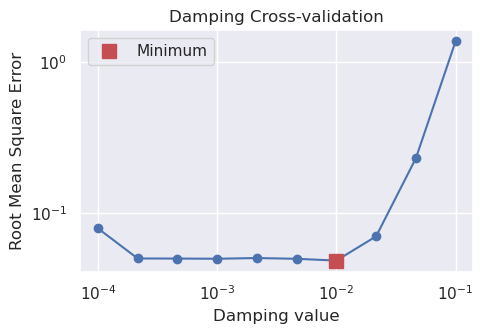

In [33]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist

# set kwargs for inversion
kwargs = dict(
    input_grav_column="Gobs_shift",
    prism_layer=starting_prisms,
    max_iterations=100,
    l2_norm_tolerance=0.14,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 1%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
    constraints=constraints,
)

fname = "../../synthetic_data/synthetic_simple_sampled_6k_damping_CV_eq_sources.pickle"
dampings = np.logspace(-4, -1, 10)
# print(f"Damping values: {dampings}")

scores, rmses = inv.inversion_optimal_parameters(
    training_data=sampled_grav[sampled_grav.test == False],
    testing_data=sampled_grav[sampled_grav.test == True],
    parameter_values=dampings,
    function=inv.inversion_damping_MSE,
    plot=False,
    plot_grids=True,
    results_fname=fname,
    progressbar=True,
    true_surface=layer1,
    inversion_region=inversion_region,
    **kwargs,
)

# put scores and damping values into dict
CV_results = dict(scores=scores, dampings=dampings, rmses=rmses)

# remove if exists
pathlib.Path(fname).unlink(missing_ok=True)

# save scores and dampings to pickle
with open(f"{fname}.pickle", "wb") as f:
    pickle.dump(CV_results, f)

# load scores and dampings from pickle
with open(f"{fname}.pickle", "rb") as f:
    CV_results = pickle.load(f)

best = np.argmin(CV_results["scores"])
print("Best score:", CV_results["scores"][best])
print("Best damping:", CV_results["dampings"][best])

# get best inversion result of each set
with open(f"{fname}_trial_{best}.pickle", "rb") as f:
    inv_result = pickle.load(f)

plotting.plot_parameter_cv(
    CV_results["scores"],
    CV_results["dampings"],
    logx=True,
    logy=True,
    param_name="Damping",
)

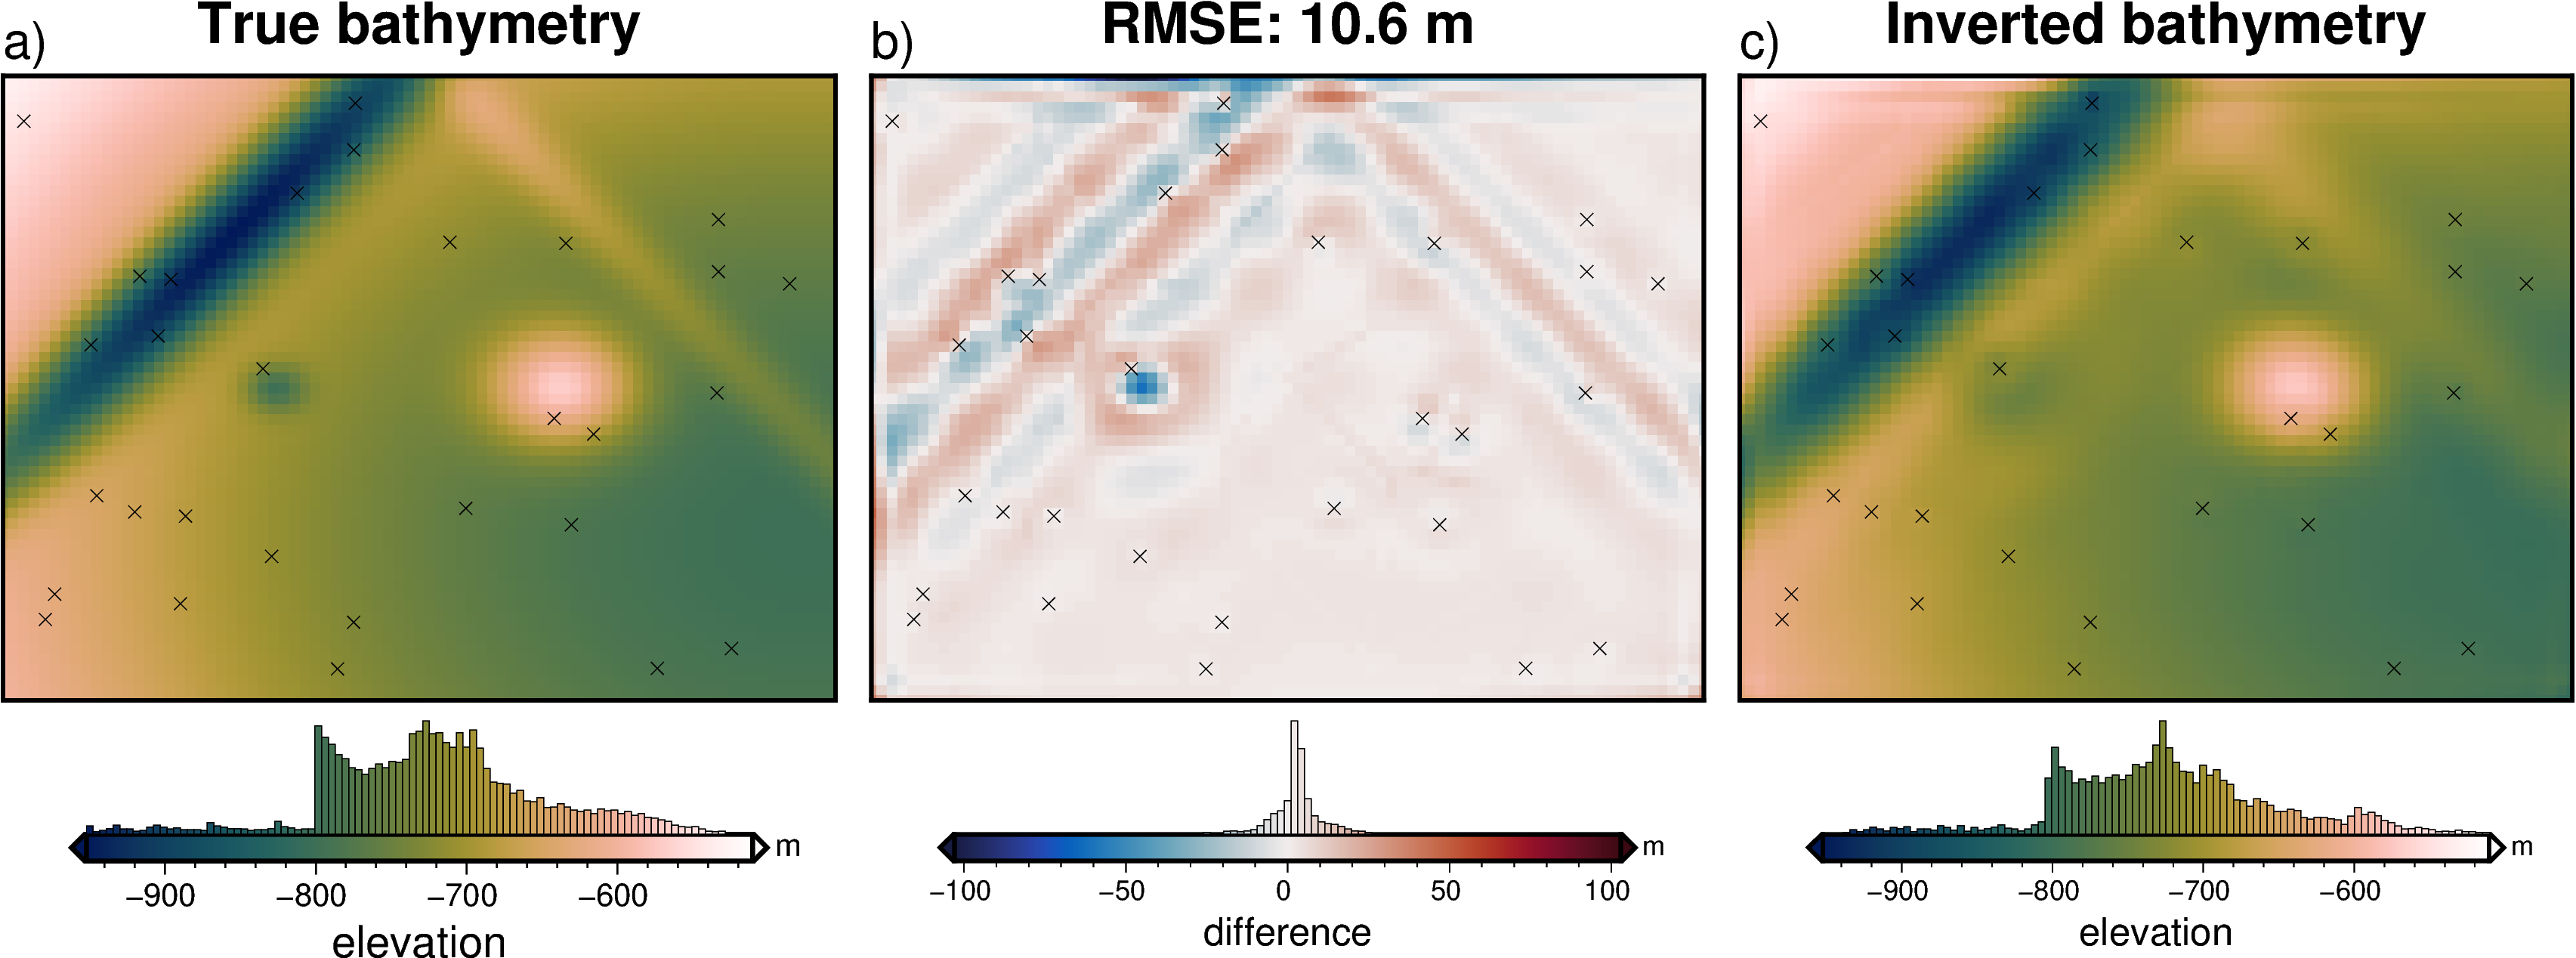

RMSE: 10.550470946715063
constraints RMSE: 1.08


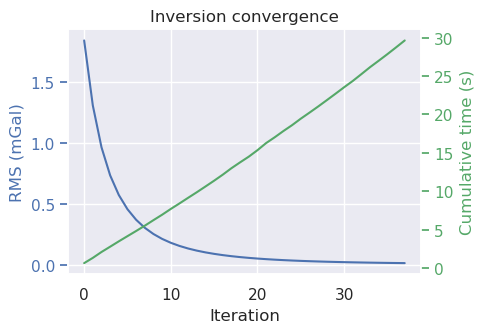

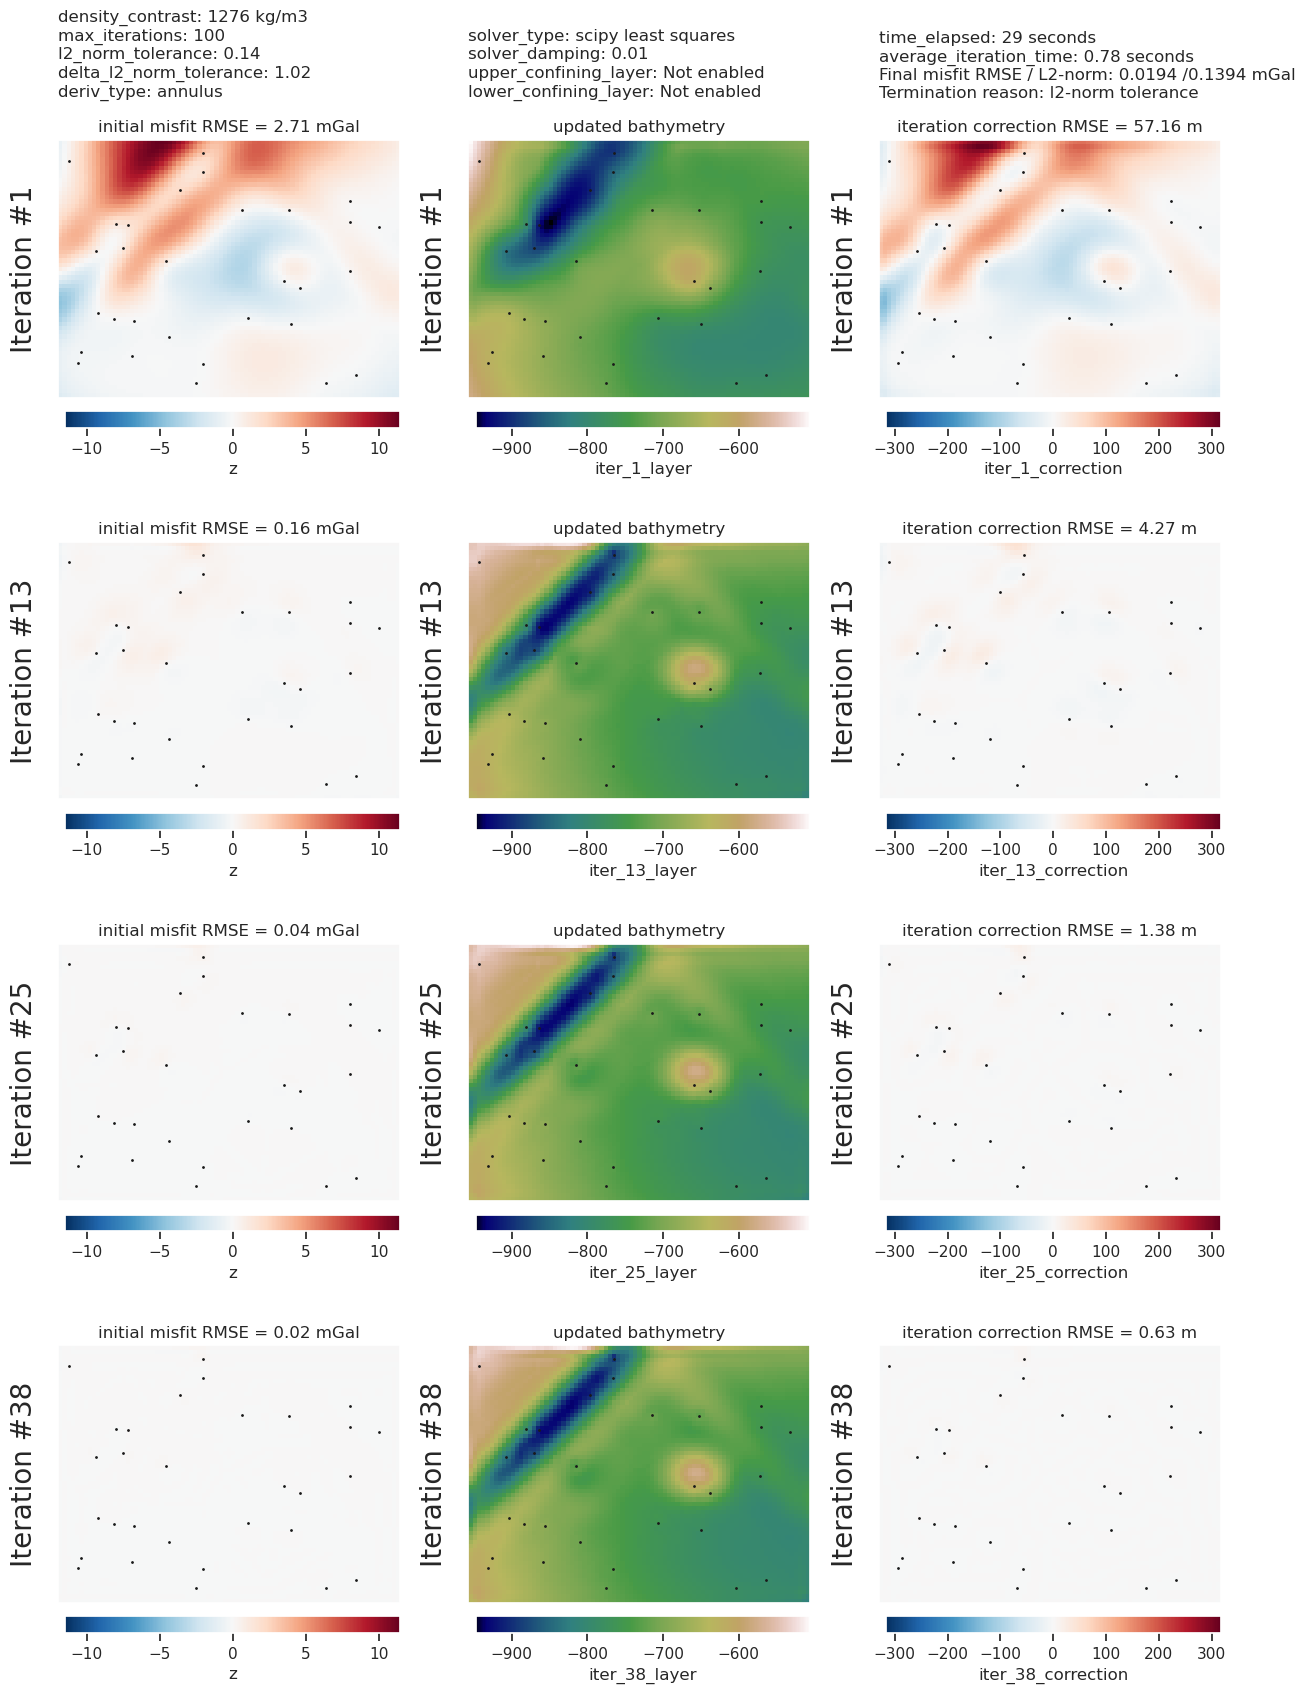

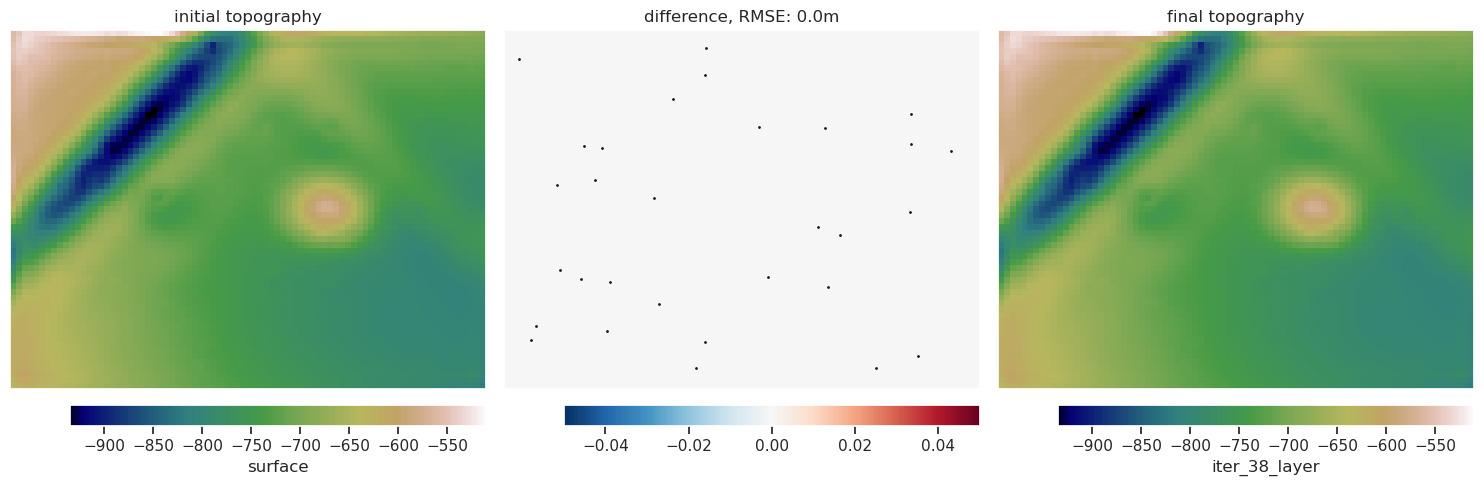

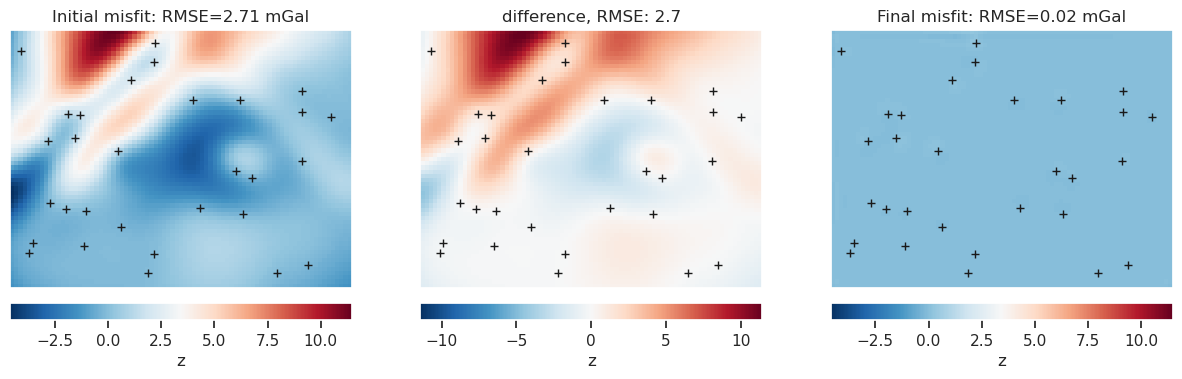

In [34]:
with inv_utils.HiddenPrints():
    _ = inv.inversion_RMSE(
        results=inv_result,
        input_grav=sampled_grav[sampled_grav.test == False],
        inversion_region=inversion_region,
        true_surface=layer1,
        plot=True,
        plot_type="pygmt",
        label_offset="j0c/.2c",
        **kwargs,
    )

plotting.plot_convergence(inv_result[2], iter_times=inv_result[3]["iter_times"])

_ = plotting.plot_inversion_results(
    inv_result[2],
    inv_result[1],
    inv_result[3],
    grav_region=inversion_region,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
    iters_to_plot=4,
    grav_spacing=grav_spacing,
    constraints=constraints,
)

print(f"RMSE: {inv_result[0]}")
print(f"constraints RMSE: {inv_result[-1]}")

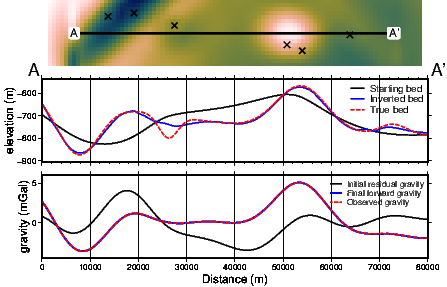

In [35]:
plotting.plot_inversion_results_profile(
    inv_result[1],
    inv_result[2],
    input_forward_column="layer1_forward",
    constraints=constraints,
    true_surface=layer1,
    start=[inversion_region[0], 30e3],
    stop=[inversion_region[1], 30e3],
    map_buffer=0.1,
    subplot_orientation="vertical",
    data_legend_loc="jTR+o0c",
    layers_legend_loc="jTR+o0c",
)

# Optimize on damping for ensemble of noise levels and cell sizes

## create set of grav dataframe with various levels of noise and grid spacings

In [ ]:
# noise_levels = [0, .09] # decimal percent gaussian noise
# cell_sizes = [2e3, 10e3] # cell size to resample gravity data at
noise_levels = [
    0,
    0.01,
    0.02,
    0.03,
    0.04,
    0.05,
    0.06,
    0.07,
    0.08,
    0.09,
]  # decimal percent gaussian noise
cell_sizes = [
    1e3,
    2e3,
    3e3,
    4e3,
    5e3,
    6e3,
    7e3,
    8e3,
    9e3,
    10e3,
]  # cell size to resample gravity data at

param_coords = []
eq_scores = []
grav_dfs = []
noise_stddevs = []
for n, c in product(noise_levels, cell_sizes, desc="Noise/Cell Size"):
    param_coords.append([n, c])

    # sample gravity at low resolution grid, regrid at full res with eq sources
    if c == layer_spacing:
        sampled_grav = full_res_grav.copy()
        eq_score = 1
    else:
        # parameter values, if using grid search
        # num = 20
        # dampings = list(np.logspace(-6, 2, num=num-1))
        # dampings.append(None)
        # depths = np.linspace(1, 50e3, num)

        # parameter ranges, if using optimization
        dampings = [10**-5, 2]
        depths = [1, 50e3]

        sampled_grav, eq_score = inv_utils.resample_gravity_with_test_points(
            grav_df=full_res_grav,
            grav_column="Gobs",
            coord_columns=["easting", "northing", "upward"],
            starting_training_spacing=layer_spacing,
            coarse_training_spacing=c,
            region=inversion_region,
            dampings=dampings,
            depths=depths,
            optimization=True,
            # optimization = False,
            n_trials=100,
            plot=False,
            log_fname="../../tmp_outputs/tmp",
        )
        # add layer1 starting forward grav into df
        sampled_grav["layer1_forward"] = full_res_grav.layer1_forward

    # add noise to data
    sampled_grav["Gobs"], stddev = synthetic.contaminate(
        sampled_grav.Gobs,
        stddev=n,
        percent=True,
        seed=0,
        return_stddev=True,
    )
    noise_stddevs.append(stddev)

    # recalculate misfit
    sampled_grav = inv.misfit(
        input_grav=sampled_grav,
        input_forward_column="layer1_forward",
        input_grav_column="Gobs",
        constraints=constraints,
    )

    # set regional to 0
    sampled_grav["reg"] = 0
    sampled_grav["res"] = sampled_grav.misfit

    eq_scores.append(eq_score)
    grav_dfs.append(sampled_grav)

ensemble_fname = (
    "../../synthetic_data/simple_ensemble/synthetic_simple_damping_CV_ensemble"
)

# save results to pickle dataframes
with open(f"{ensemble_fname}_anomalies.pickle", "wb") as fout:
    pickle.dump(grav_dfs, fout)
with open(f"{ensemble_fname}_noise_cellsize.pickle", "wb") as fout:
    pickle.dump(param_coords, fout)
with open(f"{ensemble_fname}_eq_scores.pickle", "wb") as fout:
    pickle.dump(eq_scores, fout)
with open(f"{ensemble_fname}_noise_stddev.pickle", "wb") as fout:
    pickle.dump(noise_stddevs, fout)

In [40]:
ensemble_fname = (
    "../../synthetic_data/simple_ensemble/synthetic_simple_damping_CV_ensemble"
)

with open(f"{ensemble_fname}_anomalies.pickle", "rb") as f:
    grav_dfs = pickle.load(f)
with open(f"{ensemble_fname}_noise_cellsize.pickle", "rb") as f:
    param_coords = pickle.load(f)
with open(f"{ensemble_fname}_eq_scores.pickle", "rb") as f:
    eq_scores = pickle.load(f)
with open(f"{ensemble_fname}_noise_stddev.pickle", "rb") as f:
    noise_stddevs = pickle.load(f)

print(len(grav_dfs))
print(len(param_coords))
print(f"max noise: {np.max(noise_stddevs)}")

100
100
max noise: 0.8517659854887001


In [64]:
starting_prisms = copy.deepcopy(layer1_prisms)

min_dist = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    # region=inversion_region,
)
starting_prisms["weights"] = min_dist

# set kwargs for inversion
inversion_kwargs = dict(
    input_grav_column="Gobs_shift",
    max_iterations=100,
    l2_norm_tolerance=0.15,  # sqrt(RMS)=l2-norm, set to sqrt(noise)
    delta_l2_norm_tolerance=1.02,  # stop if l2-norm doesnt decrease by at least 2%
    weights_after_solving=True,
    deriv_type="annulus",
    solver_type="scipy least squares",
    prism_layer=starting_prisms,
)


dampings = np.logspace(-4, -1, 10)
# dampings = [10**-1.2, 10**-1]
print(f"Damping values: {dampings}")

ensemble_fname = (
    "../../synthetic_data/simple_ensemble/synthetic_simple_damping_CV_ensemble"
)

inversion_results = []
resulting_scores = []
resulting_dampings = []
resulting_rmses = []
for i, df in enumerate(tqdm(grav_dfs)):
    noise = param_coords[i][0]
    cellsize = param_coords[i][1]

    # set name and storage for the optimization
    set_fname = f"{ensemble_fname}_noise_{noise}_cellsize_{cellsize}"

    with inv_utils.HiddenPrints():
        CV_scores, rmses = inv.inversion_optimal_parameters(
            training_data=df[df.test == False],
            testing_data=df[df.test == True],
            parameter_values=dampings,
            function=inv.inversion_damping_MSE,
            inversion_region=inversion_region,
            true_surface=layer1,
            plot=False,
            plot_grids=False,
            results_fname=set_fname,
            progressbar=False,
            **inversion_kwargs,
        )

    # put all scores and damping values into dict
    CV_results = dict(CV_scores=CV_scores, dampings=dampings, rmses=rmses)

    # remove if exists
    pathlib.Path(f"{set_fname}.pickle").unlink(missing_ok=True)

    # save scores and dampings of each set to pickle
    with open(f"{set_fname}.pickle", "wb") as f:
        pickle.dump(CV_results, f)

    # load scores and dampings of each set of noise/sampling
    with open(f"{set_fname}.pickle", "rb") as f:
        CV_results = pickle.load(f)

    # get best parameters of each set
    best = np.argmin(CV_results["CV_scores"])
    best_score = CV_results["CV_scores"][best]
    best_rmse = CV_results["rmses"][best]
    best_damping = CV_results["dampings"][best]

    # get best inversion result of each set
    with open(f"{set_fname}_trial_{best}.pickle", "rb") as f:
        inv_result = pickle.load(f)

    inversion_results.append(inv_result)
    resulting_dampings.append(best_damping)
    resulting_scores.append(best_score)
    resulting_rmses.append(best_rmse)

    # delete other results to save space
    fnames = []
    for i in range(len(dampings)):
        if i == best:
            pass
        else:
            fnames.append(f"{set_fname}_trial_{i}.pickle")
    for f in fnames:
        pathlib.Path(f).unlink(missing_ok=True)


df = pd.DataFrame(
    {
        "noise": [x[0] for x in param_coords[0 : len(resulting_scores)]],
        "cell_size": [x[1] for x in param_coords[0 : len(resulting_scores)]],
        "Score": resulting_scores,
        "RMSE": resulting_rmses,
        "Damping": resulting_dampings,
        "Eq source score": eq_scores[0 : len(resulting_scores)],
    }
)
df.to_csv(
    f"{ensemble_fname}.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)
df

Damping values: [0.06309573444801933, 0.1]


  0%|          | 0/4 [00:00<?, ?it/s]

noise  cell_size     Score       RMSE   Damping  Eq source score
0   0.00     2000.0  2.333271  60.473010  0.063096         0.938226
1   0.00    10000.0  2.519857  61.302525  0.063096         0.585172
2   0.09     2000.0  2.510033  61.632890  0.063096         0.773865
3   0.09    10000.0  2.808450  61.112764  0.063096         0.560234

In [9]:
ensemble_fname = (
    "../../synthetic_data/simple_ensemble/synthetic_simple_damping_CV_ensemble"
)

df = pd.read_csv(
    f"{ensemble_fname}.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
df.sort_values(by="Score")

noise  cell_size     Score       RMSE  Damping  Eq source score
0    0.00     1000.0  0.047721   8.069290     0.01         1.000000
2    0.00     3000.0  0.047725   8.138147     0.01         0.998791
1    0.00     2000.0  0.047978   8.214020     0.01         0.999906
3    0.00     4000.0  0.048944   9.052781     0.01         0.991284
4    0.00     5000.0  0.049874  11.307565     0.01         0.948273
..    ...        ...       ...        ...      ...              ...
92   0.09     3000.0  0.792370  27.203339     0.01         0.999301
90   0.09     1000.0  0.792823  27.208306     0.01         1.000000
91   0.09     2000.0  0.793218  27.272807     0.01         0.999377
89   0.08    10000.0  0.876118  49.427073     0.01         0.610273
99   0.09    10000.0  0.978154  50.030847     0.01         0.610252

[100 rows x 6 columns]

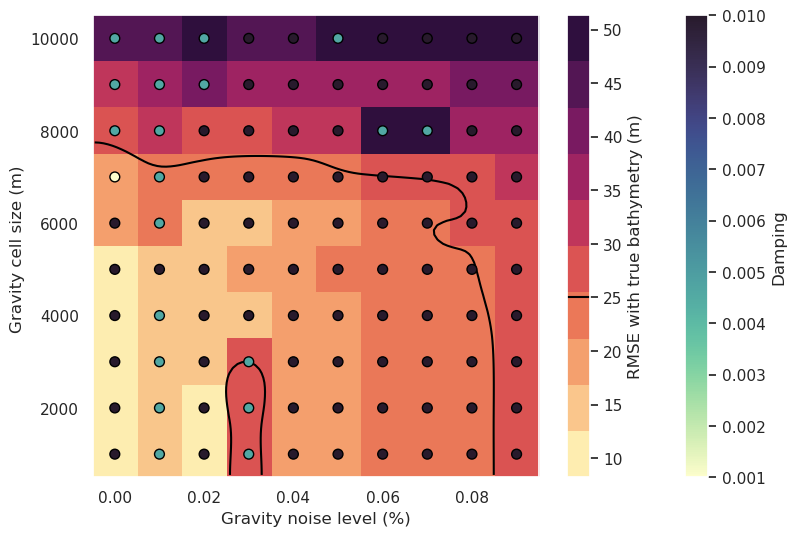

In [10]:
fig = plotting.plot_noise_cellsize_ensemble(
    df,
    background="RMSE",
    background_title="RMSE with true bathymetry (m)",
    # background="Score",
    # background_title="Gravity CV score",
    # background="Damping",
    # background_title="Damping",
    # background="Eq source score",
    # background_title="Eq source score",
    # background_color_log = True,
    background_robust=True,
    # points_color=df.RMSE,
    points_color=df.Damping,
    # points_color=df["Eq source score"],
    # points_color=df.Score,
    # points_size=df.RMSE,
    # points_size=df.Score,
    # points_scaling=80,
    # points_color_log=True,
    # points_robust=True,
    plot_contours=[25],
)

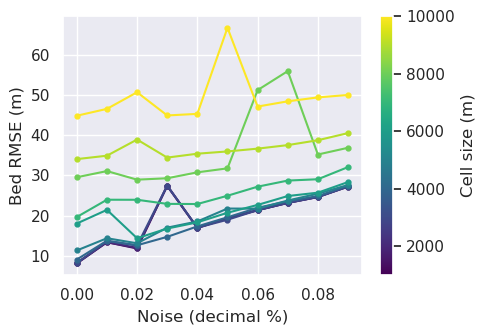

In [11]:
plotting.plot_ensemble_as_lines(
    df,
    x_col="noise",
    groupby_col="cell_size",
    x_label="Noise (decimal %)",
    cbar_label="Cell size (m)",
)

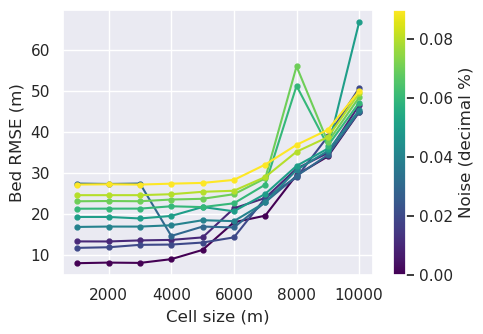

In [12]:
plotting.plot_ensemble_as_lines(
    df,
    x_col="cell_size",
    groupby_col="noise",
    x_label="Cell size (m)",
    cbar_label="Noise (decimal %)",
)

In [27]:
# # load best inversion results of each set of noise/sampling
# with open(f"{set_fname}_trial_{0}.pickle", 'rb') as f:
#     inversion_results = pickle.load(f)
# inversion_results

In [14]:
# index = df[(df.noise == 0.08) & (df.cell_size == 8e3)].index[0]
# choosen_result = inversion_results[index]
# print(df.loc[index])
# choosen_result[0]

In [15]:
# _ = inv.inversion_RMSE(
#     results=choosen_result,
#     true_surface=layer1,
#     inversion_region=inversion_region,
#     constraints=constraints,
#     plot=True,
#     plot_type="xarray",
#     # points_style="+.2c",
#     # robust=True,#False,
# )